## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'ravdess-1e5geoim' #dataset-compression
TRANSFORM = 'fft-normal_intensity' #transform-group
CHANNEL = ''

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
normal_intensity_fft_1e5geoim_ravdess.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results-audio", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'band' 
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'e:\\Research\\UCB\\Strang Lab\\Github\\hierarchical-bayesian-model-validation\\results-audio\\case-studies\\ravdess\\1e5geoim\\fft\\normal_intensity'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data-audio", "subsample-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data-audio", "subsample-data", f'{FULL_DATA_NAME}-size.pickle'))
NUM_BANDS = int(10) #Change to len(group_data_map) to use all bands

In [6]:
if 'erb' in TRANSFORM:
    group_data_map.popitem()
    print(group_data_map)

In [7]:
#if 'fourier' in TRANSFORM:
#    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
#elif 'wavelet' in TRANSFORM:
#    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)
#GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::max(len(group_data_map) // NUM_BANDS, 1)]
GROUPS = np.linspace(2, sorted(group_data_map)[-1], NUM_BANDS, dtype=int)


cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
#group_total_samples
#group_data_map


Running 12760 CDFs


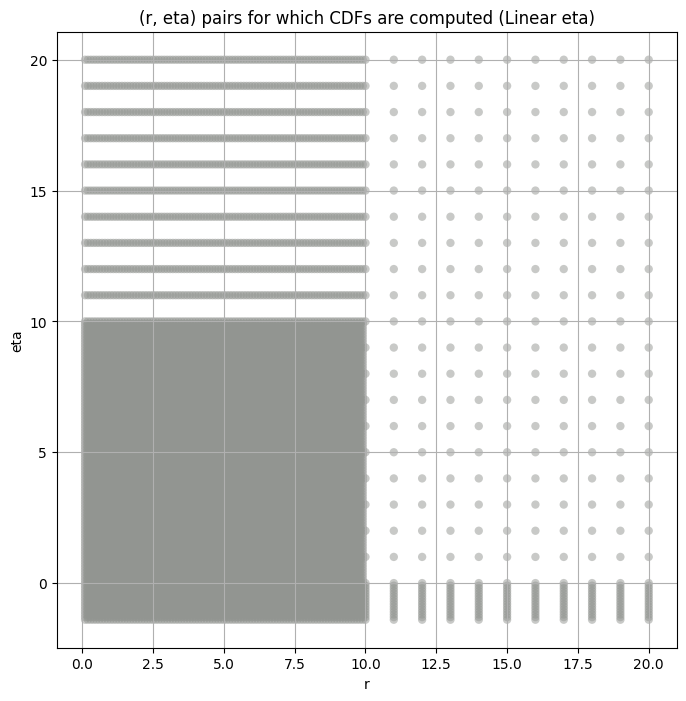

,"(r,eta),cdf",r,eta,cdf,variance,kurtosis
0,"((0.1, -1.4), <scipy.interpolate._fitpack2.Int...",0.1,-1.4,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.628800e+06,554265.000000
1,"((0.1, -1.3), <scipy.interpolate._fitpack2.Int...",0.1,-1.3,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.991680e+07,96192.272727
2,"((0.1, -1.2), <scipy.interpolate._fitpack2.Int...",0.1,-1.2,<scipy.interpolate._fitpack2.InterpolatedUniva...,2.395008e+08,29390.000000
3,"((0.1, -1.1), <scipy.interpolate._fitpack2.Int...",0.1,-1.1,<scipy.interpolate._fitpack2.InterpolatedUniva...,1.037837e+09,11997.692308
4,"((0.1, -1.0), <scipy.interpolate._fitpack2.Int...",0.1,-1.0,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.632429e+09,5874.890110


In [8]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [9]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [10]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Band 2


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 8


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 11


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 14


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 17


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 20


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 23


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 26


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 30


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples
band,,,,,,,
2,2.832722e+14,2.434444e+14,3.325068e+14,9.531164,2.694812,15.466679,1536.0
5,5.272261e+14,4.412827e+14,6.209130e+14,38.215220,31.712398,44.757256,4608.0
8,7.540515e+13,6.223850e+13,9.270398e+13,59.027773,22.559526,111.580628,13056.0
11,1.100608e+13,8.295259e+12,1.571146e+13,171.606859,11.703311,428.210304,36096.0
14,2.499094e+14,2.258673e+14,2.756166e+14,12.881619,10.170918,16.534709,99840.0
17,3.873803e+14,3.634429e+14,4.138611e+14,4.352694,2.846702,8.766469,277248.0
20,8.279530e+13,7.679648e+13,8.937748e+13,6.679419,4.341862,12.376772,769536.0
23,7.693021e+12,7.270887e+12,8.157248e+12,2.937584,1.708110,6.831796,2137344.0
26,3.254223e+12,3.037162e+12,3.503769e+12,5.574509,3.256359,14.406480,5931264.0


## Initial Grid Search and Hypothesis Test Plots

In [11]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [12]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

,obs_var,var_exclude_0,var_exclude_25,var_exclude_50,var_exclude_75,var_exclude_100,var_exclude_150,var_exclude_200,var_exclude_250,var_exclude_300,var_exclude_350,var_exclude_500
band,,,,,,,,,,,,
2,2.832722e+14,2.832722e+14,2.043168e+14,1.792676e+14,1.623757e+14,1.479192e+14,1.254047e+14,1.079862e+14,9.408438e+13,8.267296e+13,7.266903e+13,4.944731e+13
5,5.272261e+14,5.272261e+14,3.123145e+14,2.333238e+14,1.960407e+14,1.724797e+14,1.431075e+14,1.265250e+14,1.150492e+14,1.062802e+14,9.890773e+13,8.170741e+13
8,7.540515e+13,7.540515e+13,5.571512e+13,5.064699e+13,4.735393e+13,4.507820e+13,4.195721e+13,3.965236e+13,3.782845e+13,3.631668e+13,3.507336e+13,3.213535e+13
11,1.100608e+13,1.100608e+13,8.091549e+12,7.746386e+12,7.529590e+12,7.366071e+12,7.116143e+12,6.926106e+12,6.777224e+12,6.651499e+12,6.540508e+12,6.272329e+12
14,2.499094e+14,2.499094e+14,2.401769e+14,2.337856e+14,2.284463e+14,2.236733e+14,2.152826e+14,2.080044e+14,2.015989e+14,1.957858e+14,1.904039e+14,1.762863e+14
17,3.873803e+14,3.873803e+14,3.776034e+14,3.716527e+14,3.667774e+14,3.625706e+14,3.552740e+14,3.489284e+14,3.431921e+14,3.379847e+14,3.331651e+14,3.203096e+14
20,8.279530e+13,8.279530e+13,8.009951e+13,7.852915e+13,7.724159e+13,7.611733e+13,7.419233e+13,7.253478e+13,7.106194e+13,6.972661e+13,6.849848e+13,6.528276e+13
23,7.693021e+12,7.693021e+12,7.521919e+12,7.423246e+12,7.341597e+12,7.270077e+12,7.145965e+12,7.038304e+12,6.941703e+12,6.853150e+12,6.771096e+12,6.552667e+12
26,3.254223e+12,3.254223e+12,3.158930e+12,3.105462e+12,3.061354e+12,3.022784e+12,2.955923e+12,2.898188e+12,2.846822e+12,2.800074e+12,2.756969e+12,2.643756e+12


####
Band  2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 0 0.008137220343014562 283272216951497.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 25 0.013666216114415541 204316819166690.53


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 50 0.02429627152323477 179267626770222.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 75 0.0356010924126865 162375743044192.94


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 100 0.046189566477412486 147919248975875.6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 150 0.06464460055550958 125404663899876.98


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 200 0.08084185580046321 107986162332621.89


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 250 0.09515180119879585 94084383048179.42


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 300 0.10793625085787284 82672957427703.2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 350 0.12014351293574199 72669029257614.86


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 500 0.15509972898158741 49447309361705.64
Number of samples: 3072, Without approximation : 1536.0


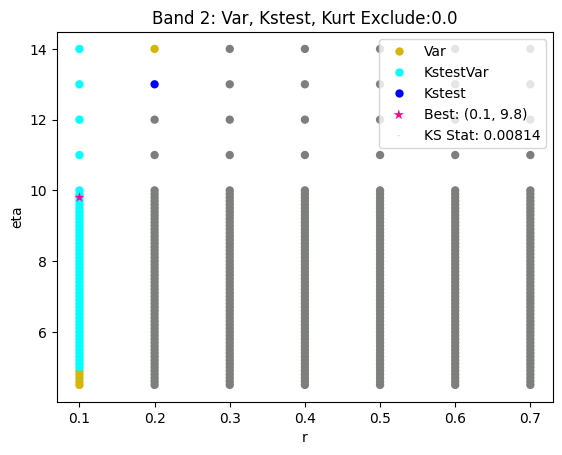

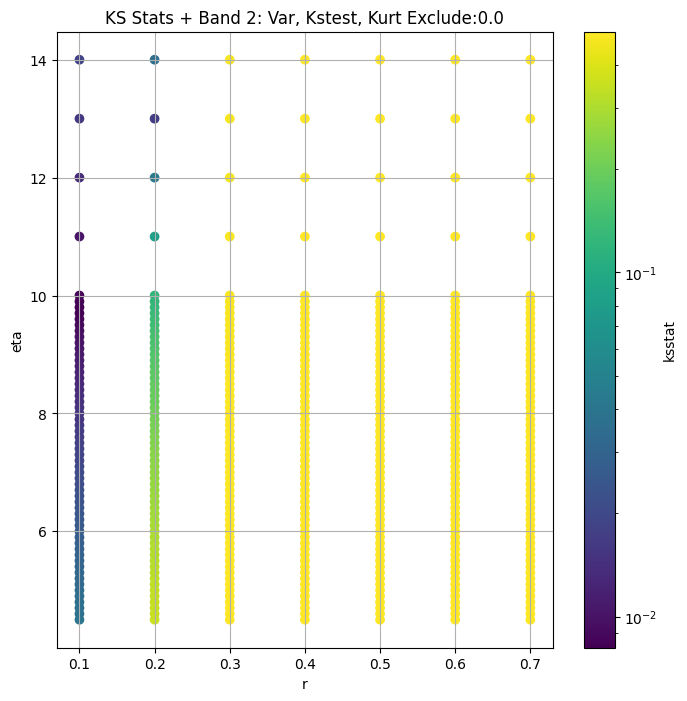

####
Band  5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 0 0.01629867762239301 527226119294584.3


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 25 0.01629867762239301 312314523075725.06


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 50 0.011356437355940274 233323803666756.56


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 75 0.011065332886798408 196040708189492.1


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 100 0.012681930962361532 172479656719896.94


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 150 0.019511894246693917 143107467645834.44


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 200 0.02558973535765552 126524990911030.86


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 250 0.029762197133490487 115049226304409.66


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 300 0.03490631048259363 106280161630893.44


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 350 0.04197060642119688 98907732364028.33


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 500 0.061911105999645374 81707412807602.7
Number of samples: 9216, Without approximation : 4608.0


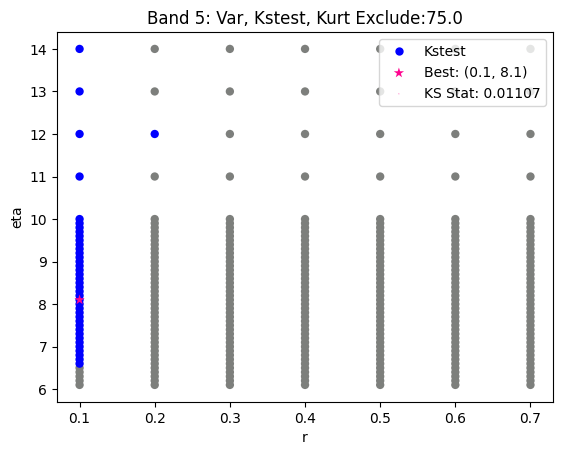

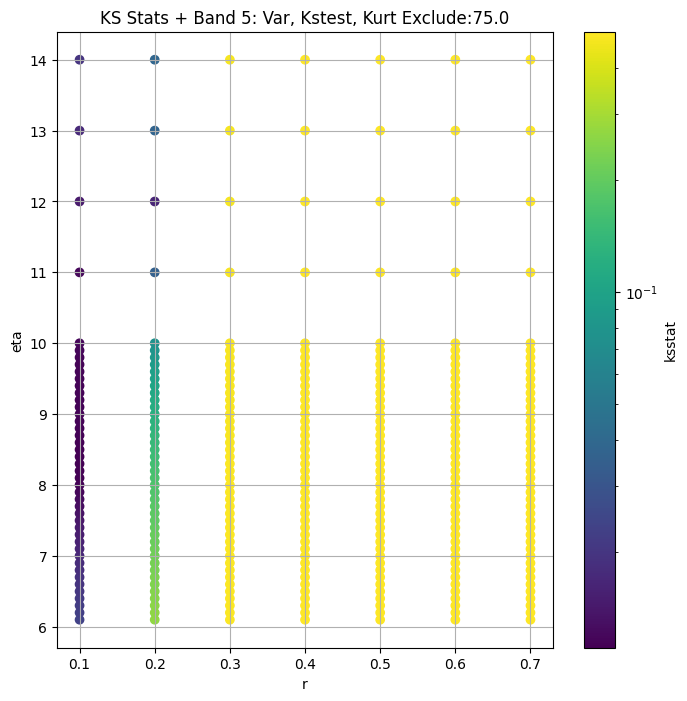

####
Band  8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 0 0.006001471811569625 75405150154984.33


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 25 0.006001471811569625 55715124490045.39


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 50 0.006001471811569625 50646988043330.15


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 75 0.006001471811569625 47353932445405.09


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 100 0.006184187274685393 45078199737423.234


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 150 0.007306731030060114 41957212264392.08


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 200 0.009162007200648137 39652355616086.74


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 250 0.01110675177354048 37828448980391.42


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 300 0.014142366797706418 36316681829005.695


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 350 0.017349662835951185 35073364606328.895


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 500 0.02512500318577815 32135348060864.137
Number of samples: 26112, Without approximation : 13056.0


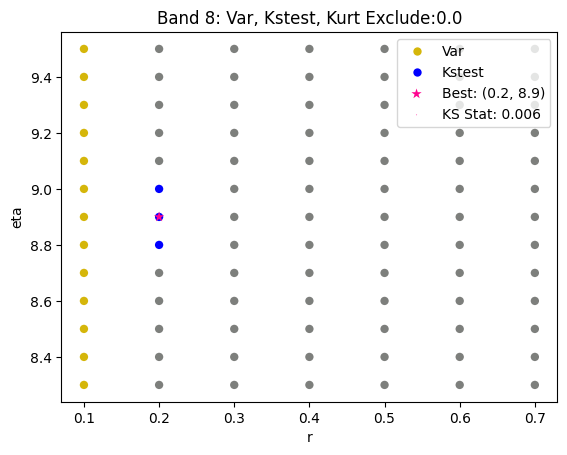

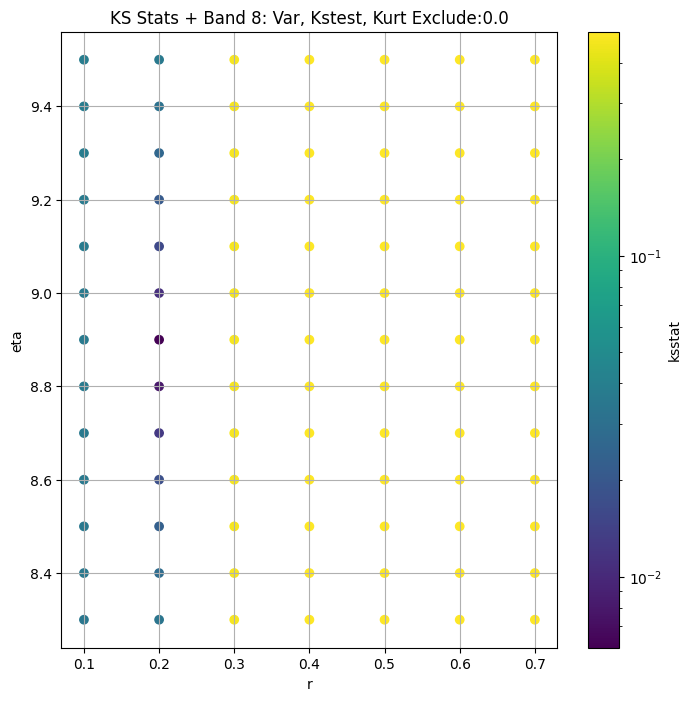

####
Band  11


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 0 0.010028224462498792 11006076049588.053


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 25 0.007857285252329982 8091549251242.827


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 50 0.005719665333417057 7746386120175.847


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 75 0.004463528209227352 7529589703875.905


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 100 0.003445365460359895 7366071195786.939


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 150 0.0030463115545676994 7116143203582.373


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 200 0.0033477930766265818 6926105577590.977


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 250 0.004170250273580499 6777223636349.842


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 300 0.00527473104101725 6651498666092.942


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 350 0.007193688856797609 6540508186954.362


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 500 0.011974712136748944 6272328972911.218
Number of samples: 72192, Without approximation : 36096.0


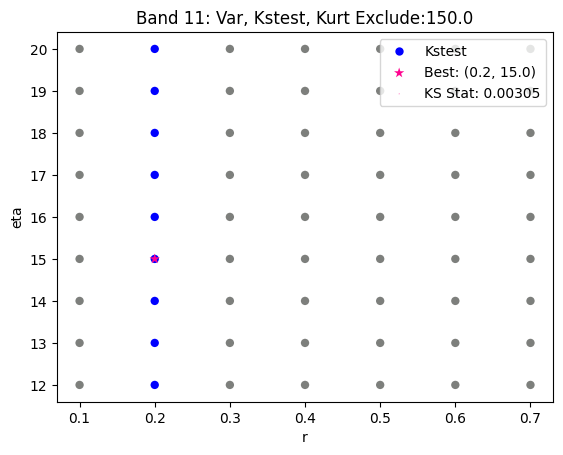

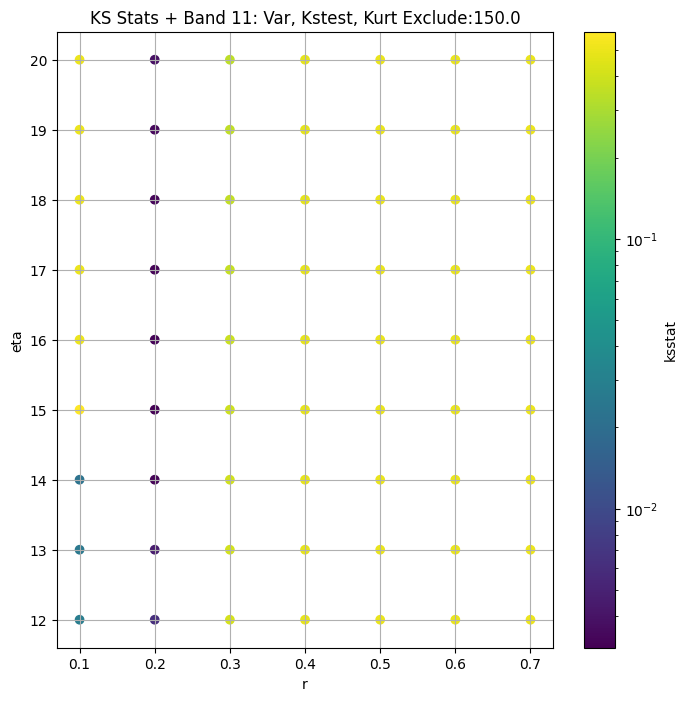

####
Band  14


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 0 0.028720476536286954 249909383567753.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 25 0.028317805587874167 240176937086017.72


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 50 0.02934022735580072 233785603359982.34


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 75 0.030208015086290174 228446257937698.78


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 100 0.031019065045522626 223673273069547.06


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 150 0.0298445284962828 215282573054278.84


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 200 0.03115528127260607 208004378243714.25


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 250 0.032332611426973905 201598854744238.62


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 300 0.03130500666273561 195785810207979.1


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 350 0.03220735579777721 190403850021244.06


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 500 0.03308782769804615 176286342673431.3
Number of samples: 100000, Without approximation : 99840.0


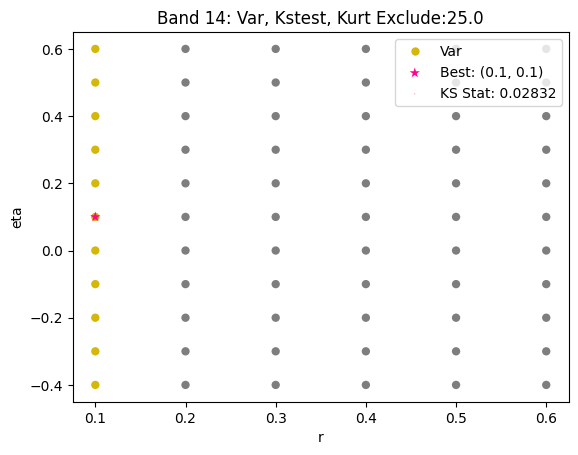

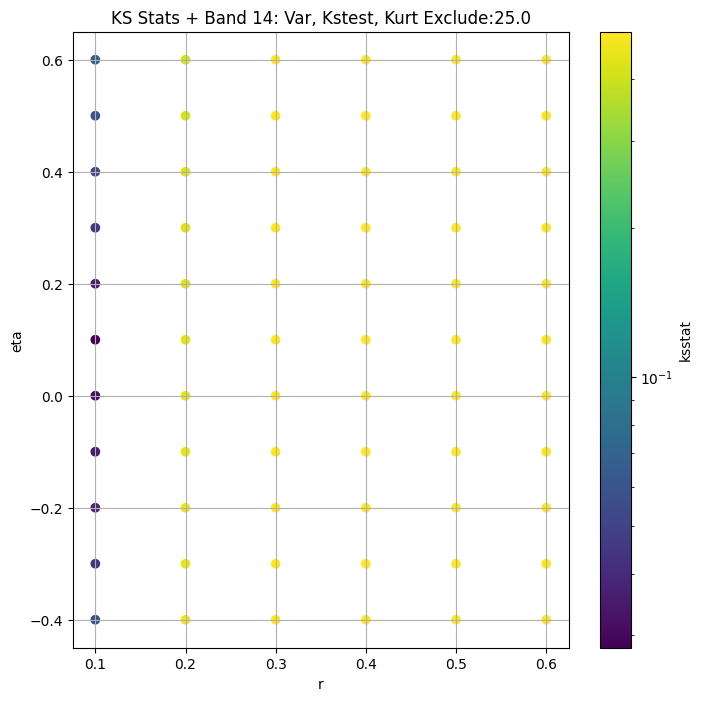

####
Band  17


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 0 0.00517385737719489 387380286846714.94


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 25 0.005927714115474589 377603437383205.3


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 50 0.006478605790545142 371652654282580.56


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 75 0.0068707795539221656 366777384122150.8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 100 0.007333220935769935 362570587575219.6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 150 0.008035086097321606 355273950714683.2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 200 0.00864739865588142 348928359839371.7


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 250 0.009246441173861794 343192133431507.06


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 300 0.01015205558006095 337984693467843.7


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 350 0.01085437597426997 333165076072391.6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 500 0.012254084429930423 320309572434074.3
Number of samples: 100000, Without approximation : 277248.0


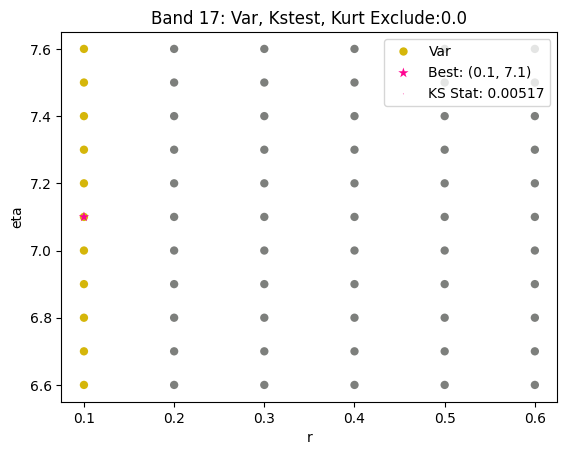

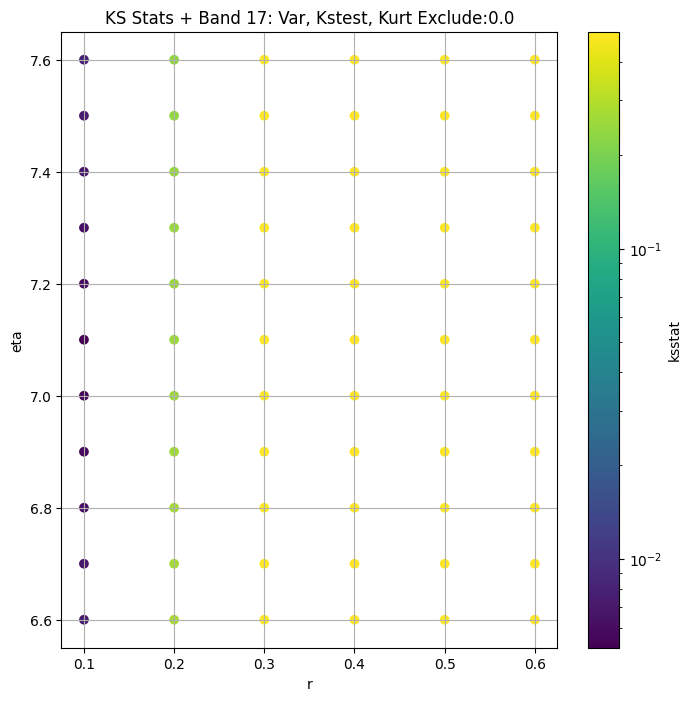

####
Band  20


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 0 0.0031832379209393302 82795303596983.36


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 25 0.00228751257926213 80099508108964.72


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 50 0.0018610368683823052 78529148837274.02


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 75 0.0023070454392950385 77241589826805.55


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 100 0.002817075167168153 76117328331096.31


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 150 0.00376430448017831 74192332042956.08


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 200 0.004638207289733465 72534784562514.97


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 250 0.005443982195605244 71061936765080.69


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 300 0.006210578505799445 69726607305452.836


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 350 0.0069308492809157865 68498483291348.24


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 500 0.009014461554168539 65282757738444.12
Number of samples: 100000, Without approximation : 769536.0


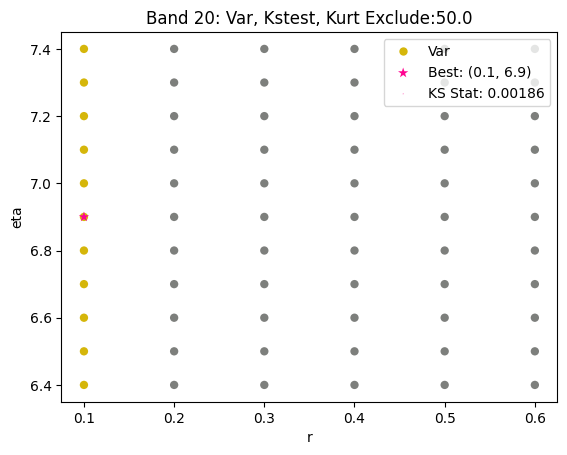

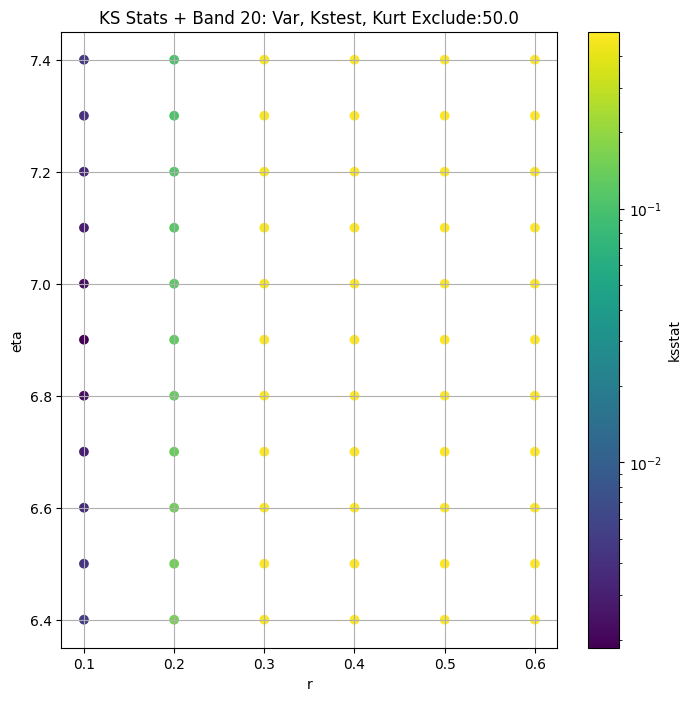

####
Band  23


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 0 0.0014769860564176618 7693020803365.627


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 25 0.0005293586634348424 7521918865241.804


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 50 0.000939508194429825 7423245673630.563


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 75 0.0014005146765386015 7341596713143.014


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 100 0.0019309658298629698 7270076658381.725


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 150 0.0029032218718560918 7145965244907.511


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 200 0.0037735309116747953 7038304130935.536


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 250 0.004594120530403291 6941702686143.324


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 300 0.005357900537007174 6853149594600.857


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 350 0.006080289801188528 6771095849027.634


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 500 0.008103091781541089 6552667397974.625
Number of samples: 100000, Without approximation : 2137344.0


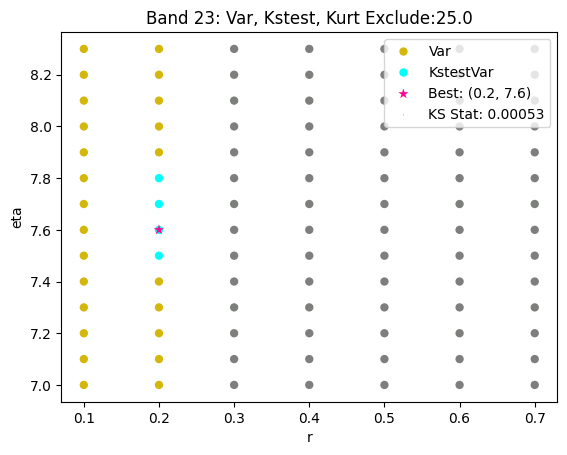

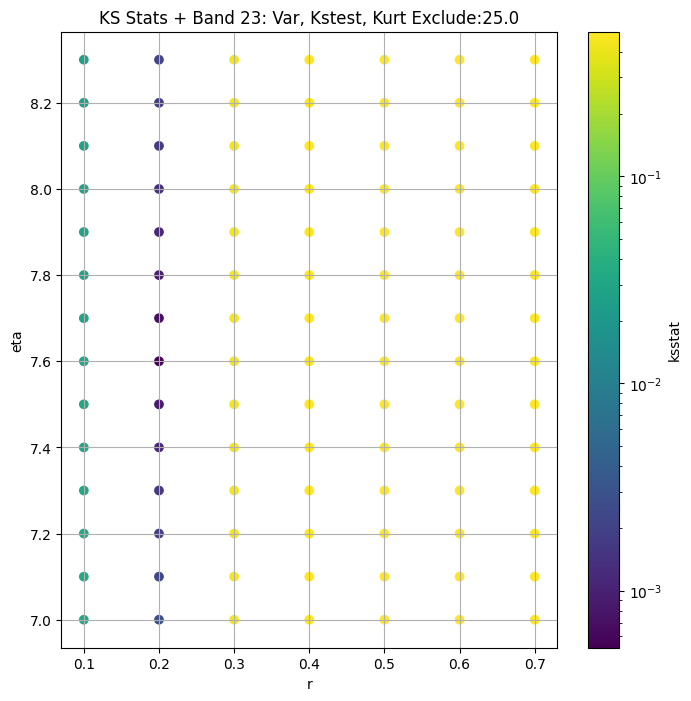

####
Band  26


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 0 0.0006515677471151254 3254223044640.0996


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 25 0.0017179827575023246 3158929517084.114


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 50 0.0024071736054462195 3105461675520.306


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 75 0.0030319379365425086 3061353797508.89


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 100 0.0035254139974346607 3022784307518.6685


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 150 0.004506844075863076 2955922639113.8345


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 200 0.005288753837117244 2898187879054.4185


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 250 0.005784832678116851 2846821515158.679


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 300 0.006553636240439115 2800073860149.2646


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 350 0.007324837216418037 2756969020204.999


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 500 0.009439213878327767 2643756086107.907
Number of samples: 100000, Without approximation : 5931264.0


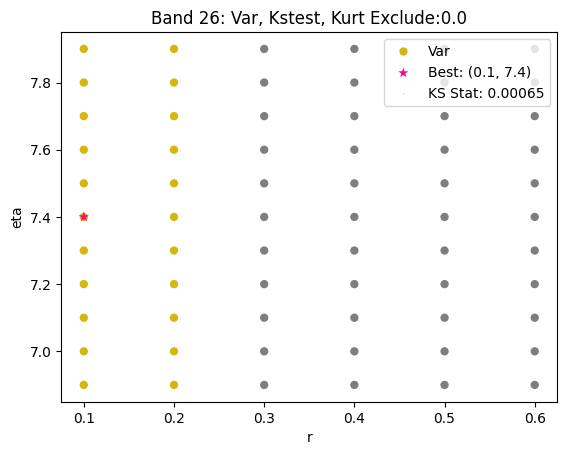

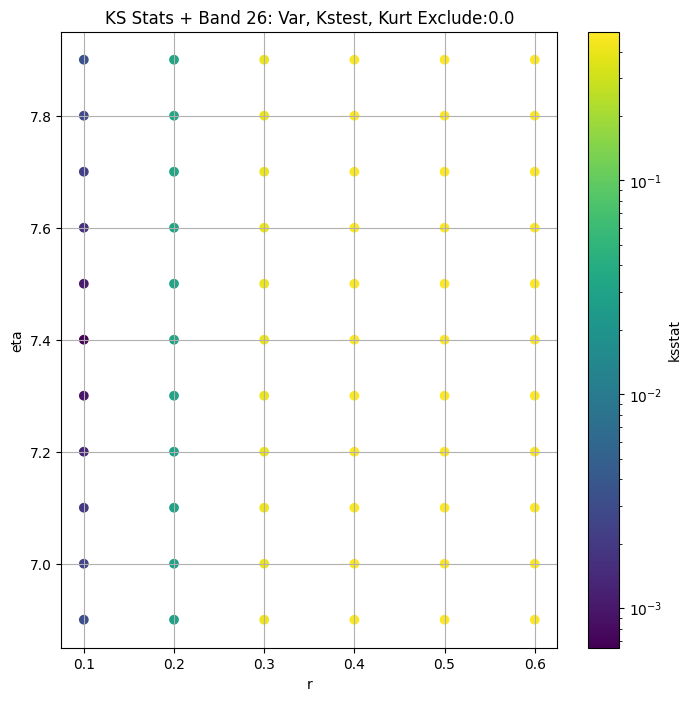

####
Band  30


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 0 0.002461287372529042 45077196257.25905


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 25 0.002655293427944759 43571559025.70588


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 50 0.0033347465419997224 42676897987.572975


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 75 0.004072315314311736 41936678333.32487


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 100 0.004530260328685025 41287213134.08329


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 150 0.005574451136377737 40162341656.605316


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 200 0.006301783445017244 39191143884.79818


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 250 0.007164884875772222 38326083791.4023


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 300 0.007969742081859604 37539906092.71425


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 350 0.008604574994386126 36816162679.26573


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
30 500 0.010667018545852863 34915997884.25399
Number of samples: 100000, Without approximation : 4459008.0


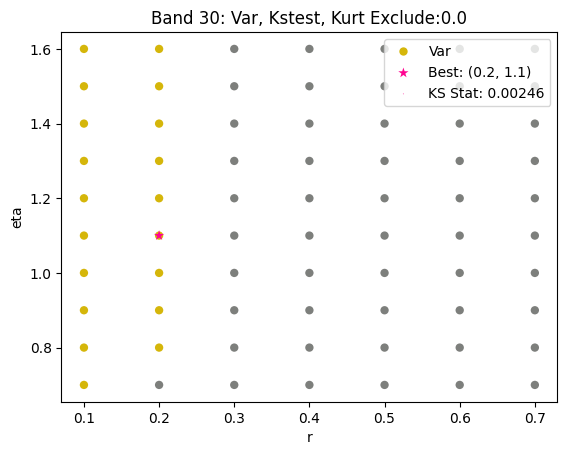

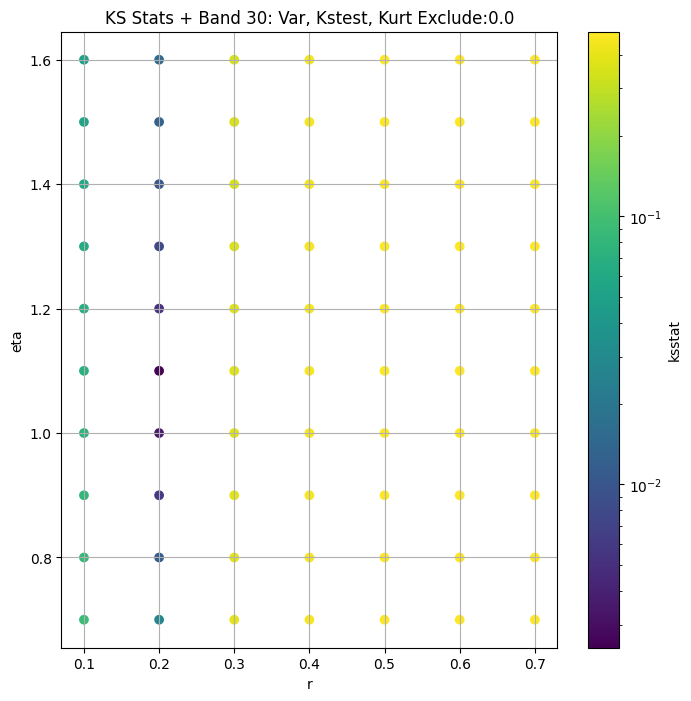

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,kstest_stat_initial,initial_r,initial_eta,initial_scale,initial_exclude_cutoff,best_augmented_var,kstest_stat_cutoff_0.05
band,,,,,,,,,,,,,,
2,2.832722e+14,2.434444e+14,3.325068e+14,9.531164,2.694812,15.466679,1536.0,0.008137,0.1,9.8,5.664004e-07,0.0,2.832722e+14,0.034542
5,5.272261e+14,4.412827e+14,6.209130e+14,38.215220,31.712398,44.757256,4608.0,0.011065,0.1,8.1,1.872667e-06,75.0,1.960407e+14,0.019970
8,7.540515e+13,6.223850e+13,9.270398e+13,59.027773,22.559526,111.580628,13056.0,0.006001,0.2,8.9,1.000000e+05,0.0,7.540515e+13,0.011873
11,1.100608e+13,8.295259e+12,1.571146e+13,171.606859,11.703311,428.210304,36096.0,0.003046,0.2,15.0,1.652971e+03,150.0,7.116143e+12,0.007144
14,2.499094e+14,2.258673e+14,2.756166e+14,12.881619,10.170918,16.534709,99840.0,0.028318,0.1,0.1,2.024814e+01,25.0,2.401769e+14,0.004296
17,3.873803e+14,3.634429e+14,4.138611e+14,4.352694,2.846702,8.766469,277248.0,0.005174,0.1,7.1,1.056431e-05,0.0,3.873803e+14,0.002579
20,8.279530e+13,7.679648e+13,8.937748e+13,6.679419,4.341862,12.376772,769536.0,0.001861,0.1,6.9,2.678475e-06,50.0,7.852915e+13,0.001548
23,7.693021e+12,7.270887e+12,8.157248e+12,2.937584,1.708110,6.831796,2137344.0,0.000529,0.2,7.6,3.117624e+04,25.0,7.521919e+12,0.000929
26,3.254223e+12,3.037162e+12,3.503769e+12,5.574509,3.256359,14.406480,5931264.0,0.000652,0.1,7.4,6.402980e-08,0.0,3.254223e+12,0.000558


In [13]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [14]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Band 2


  0%|          | 0/405 [00:00<?, ?it/s]

Finding Minimum after computing 405 CDFs
band 2, 0.0 + 100 = 100, ksstat: 0.056002518152389436, var: 147919248975875.6


  0%|          | 0/405 [00:00<?, ?it/s]

Finding Minimum after computing 405 CDFs
band 2, 0.0 + 75 = 75, ksstat: 0.046120893954487374, var: 162375743044192.94


  0%|          | 0/405 [00:00<?, ?it/s]

Finding Minimum after computing 405 CDFs
band 2, 0.0 + 50 = 50, ksstat: 0.035494546112669334, var: 179267626770222.0


  0%|          | 0/405 [00:00<?, ?it/s]

Finding Minimum after computing 405 CDFs
band 2, 0.0 + 25 = 25, ksstat: 0.02130952721015497, var: 204316819166690.53


  0%|          | 0/405 [00:00<?, ?it/s]

Finding Minimum after computing 405 CDFs
band 2, 0.0 + 0 = 0, ksstat: 0.008137220343014562, var: 283272216951497.5
Number of samples: 3072, Without approximation : 1536.0


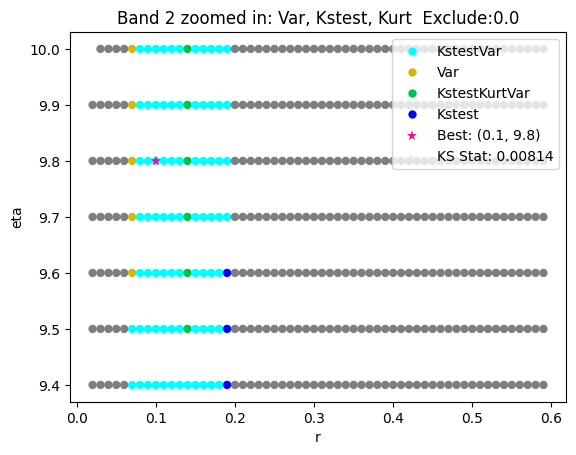

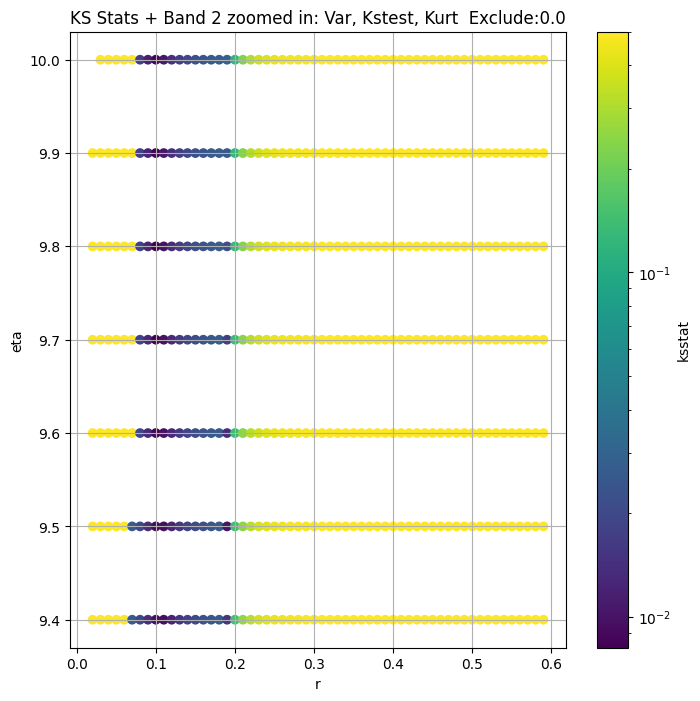

Band 5


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 75.0 + 100 = 175, ksstat: 0.022348093722914974, var: 133869052505591.22


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 75.0 + 75 = 150, ksstat: 0.01932398229479193, var: 143107467645834.44


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 75.0 + 50 = 125, ksstat: 0.015556218433071811, var: 155722074658685.28


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 75.0 + 25 = 100, ksstat: 0.012682597208325208, var: 172479656719896.94


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 75.0 + 0 = 75, ksstat: 0.011065332886798408, var: 196040708189492.1


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 75.0 + -25 = 50, ksstat: 0.011000335742357092, var: 233323803666756.56


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 75.0 + -50 = 25, ksstat: 0.020334220805620147, var: 312314523075725.06


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 75.0 + -75 = 0, ksstat: 0.020334220805620147, var: 527226119294584.3
Number of samples: 9216, Without approximation : 4608.0


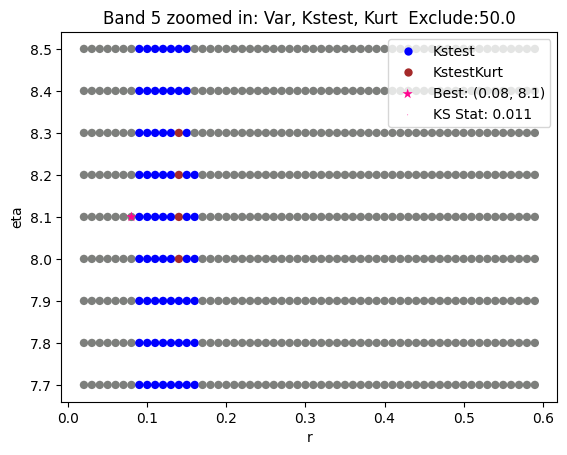

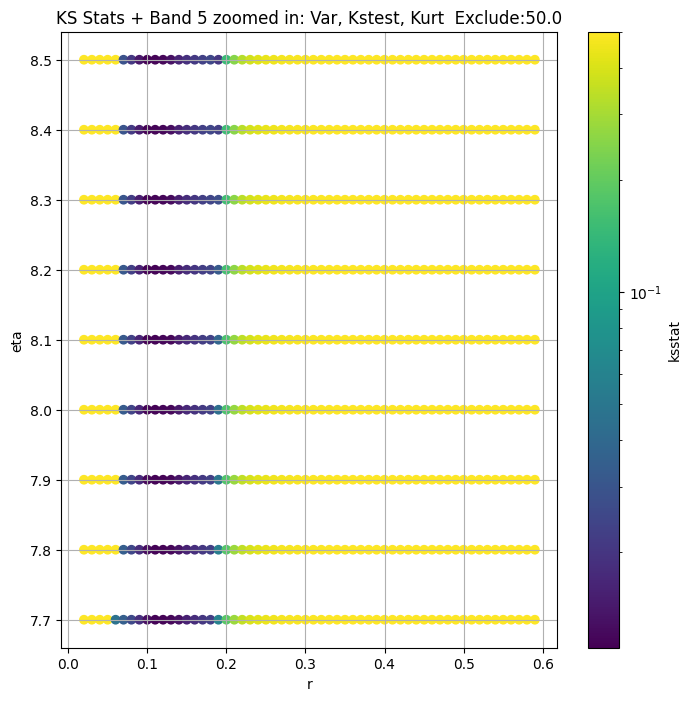

Band 8


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 8, 0.0 + 100 = 100, ksstat: 0.006094717824767115, var: 45078199737423.234


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 8, 0.0 + 75 = 75, ksstat: 0.006001471811569625, var: 47353932445405.09


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 8, 0.0 + 50 = 50, ksstat: 0.006001471811569625, var: 50646988043330.15


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 8, 0.0 + 25 = 25, ksstat: 0.006001471811569625, var: 55715124490045.39


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 8, 0.0 + 0 = 0, ksstat: 0.006001471811569625, var: 75405150154984.33
Number of samples: 26112, Without approximation : 13056.0


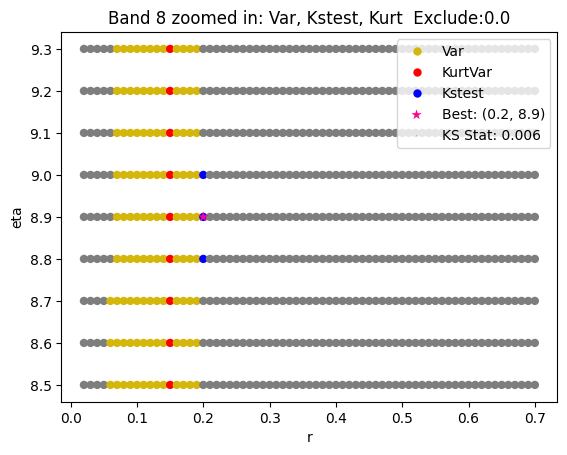

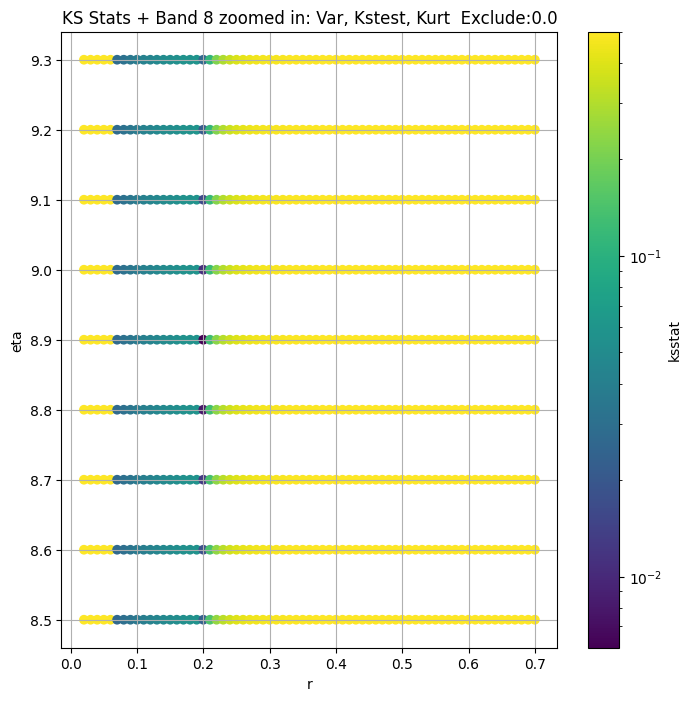

Band 11


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 11, 150.0 + 100 = 250, ksstat: 0.0049109592357940435, var: 6777223636349.842


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 11, 150.0 + 75 = 225, ksstat: 0.003750361541304148, var: 6847071832332.339


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 11, 150.0 + 50 = 200, ksstat: 0.0033295744549819133, var: 6926105577590.977


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 11, 150.0 + 25 = 175, ksstat: 0.00319718029405458, var: 7015892846532.778


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 11, 150.0 + 0 = 150, ksstat: 0.0029781493128438474, var: 7116143203582.373


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 11, 150.0 + -25 = 125, ksstat: 0.002787061120955836, var: 7231252406824.77


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 11, 150.0 + -50 = 100, ksstat: 0.0032443826790589103, var: 7366071195786.939


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 11, 150.0 + -75 = 75, ksstat: 0.004414989234391875, var: 7529589703875.905


  0%|          | 0/68 [00:00<?, ?it/s]

Finding Minimum after computing 68 CDFs
band 11, 150.0 + -100 = 50, ksstat: 0.006000917653442239, var: 7746386120175.847
Number of samples: 72192, Without approximation : 36096.0


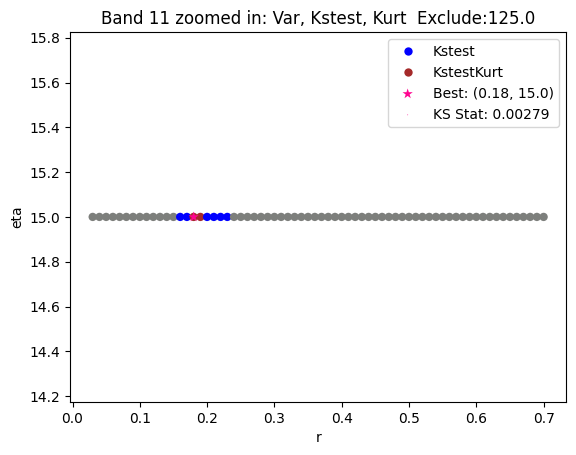

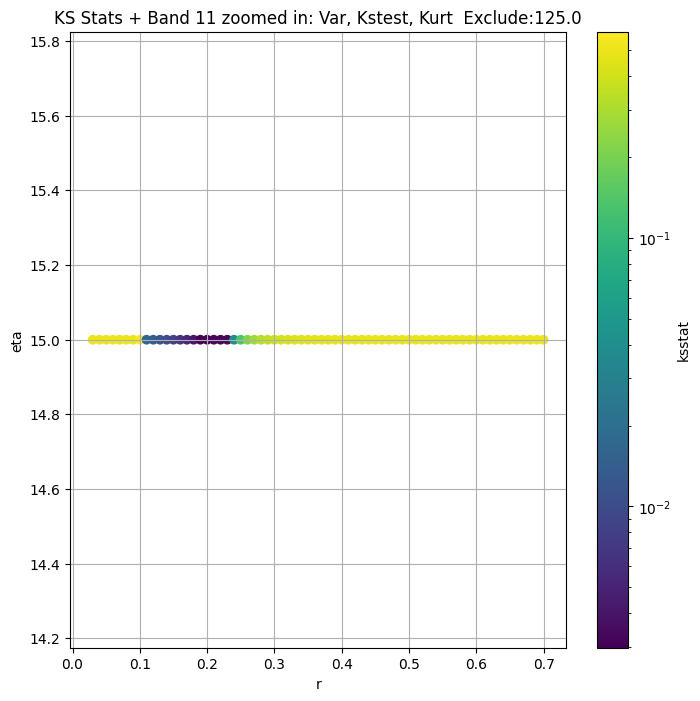

Band 14


  0%|          | 0/702 [00:00<?, ?it/s]

Finding Minimum after computing 702 CDFs
band 14, 25.0 + 100 = 125, ksstat: 0.029310910441979393, var: 219315051637456.94


  0%|          | 0/702 [00:00<?, ?it/s]

Finding Minimum after computing 702 CDFs
band 14, 25.0 + 75 = 100, ksstat: 0.028554632376621605, var: 223673273069547.06


  0%|          | 0/702 [00:00<?, ?it/s]

Finding Minimum after computing 702 CDFs
band 14, 25.0 + 50 = 75, ksstat: 0.02903624477945263, var: 228446257937698.78


  0%|          | 0/702 [00:00<?, ?it/s]

Finding Minimum after computing 702 CDFs
band 14, 25.0 + 25 = 50, ksstat: 0.028159872296279684, var: 233785603359982.34


  0%|          | 0/702 [00:00<?, ?it/s]

Finding Minimum after computing 702 CDFs
band 14, 25.0 + 0 = 25, ksstat: 0.027127616362232182, var: 240176937086017.72


  0%|          | 0/702 [00:00<?, ?it/s]

Finding Minimum after computing 702 CDFs
band 14, 25.0 + -25 = 0, ksstat: 0.02733351513348113, var: 249909383567753.5
Number of samples: 100000, Without approximation : 99840.0


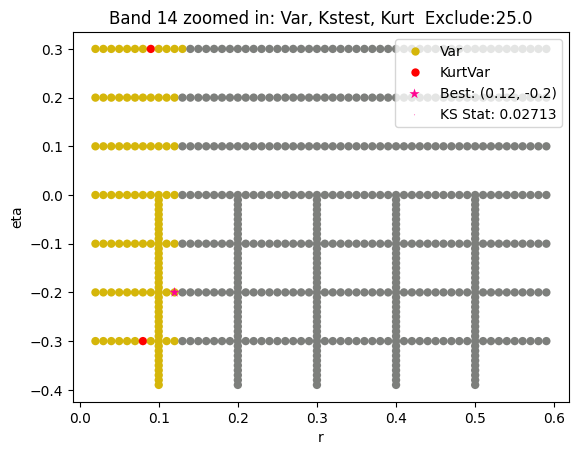

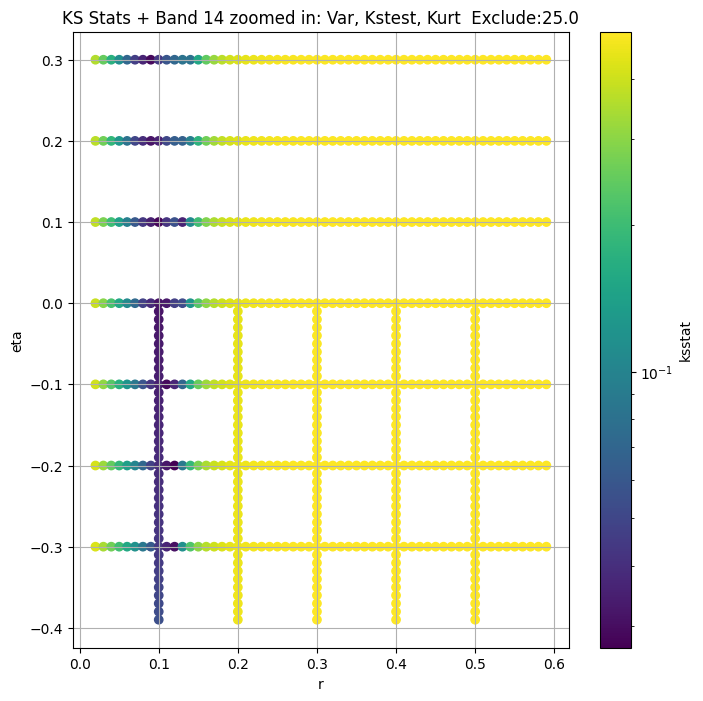

Band 17


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 17, 0.0 + 100 = 100, ksstat: 0.00717009139346092, var: 362570587575219.6


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 17, 0.0 + 75 = 75, ksstat: 0.0067947783771536985, var: 366777384122150.8


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 17, 0.0 + 50 = 50, ksstat: 0.006463756513805444, var: 371652654282580.56


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 17, 0.0 + 25 = 25, ksstat: 0.005860062582244585, var: 377603437383205.3


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 17, 0.0 + 0 = 0, ksstat: 0.00517385737719489, var: 387380286846714.94
Number of samples: 100000, Without approximation : 277248.0


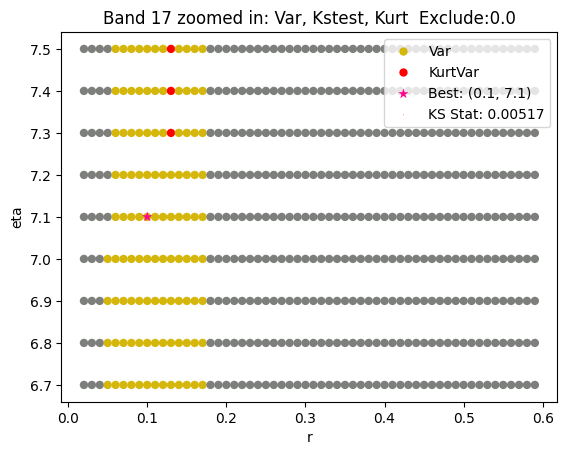

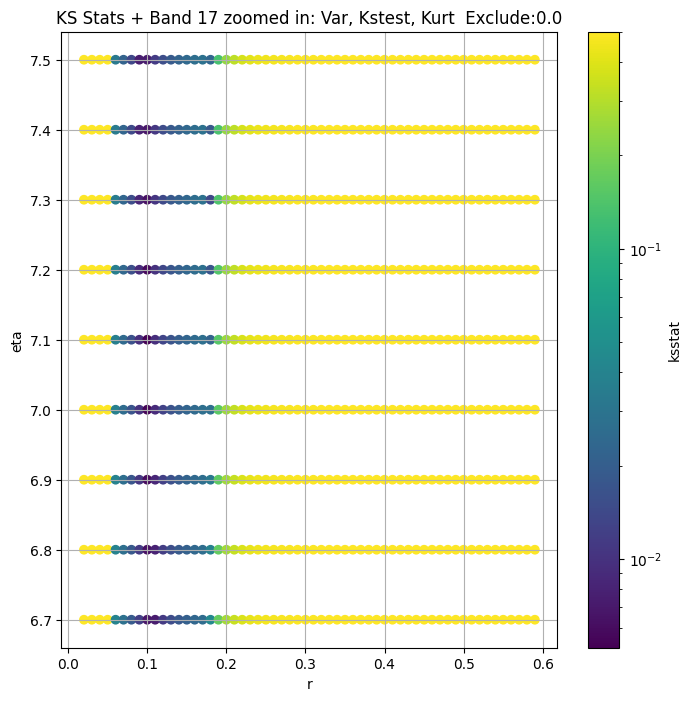

Band 20


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 20, 50.0 + 100 = 150, ksstat: 0.003720291366796427, var: 74192332042956.08


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 20, 50.0 + 75 = 125, ksstat: 0.003267200994771062, var: 75112117586848.48


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 20, 50.0 + 50 = 100, ksstat: 0.002783938415504058, var: 76117328331096.31


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 20, 50.0 + 25 = 75, ksstat: 0.0023070454392950385, var: 77241589826805.55


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 20, 50.0 + 0 = 50, ksstat: 0.0018610368683823052, var: 78529148837274.02


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 20, 50.0 + -25 = 25, ksstat: 0.00228751257926213, var: 80099508108964.72


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 20, 50.0 + -50 = 0, ksstat: 0.003130710159361283, var: 82795303596983.36
Number of samples: 100000, Without approximation : 769536.0


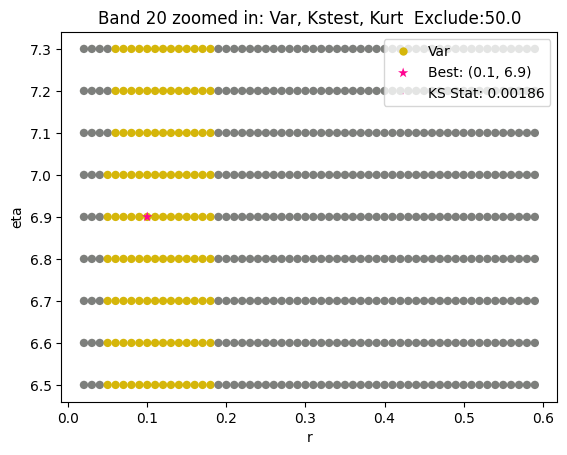

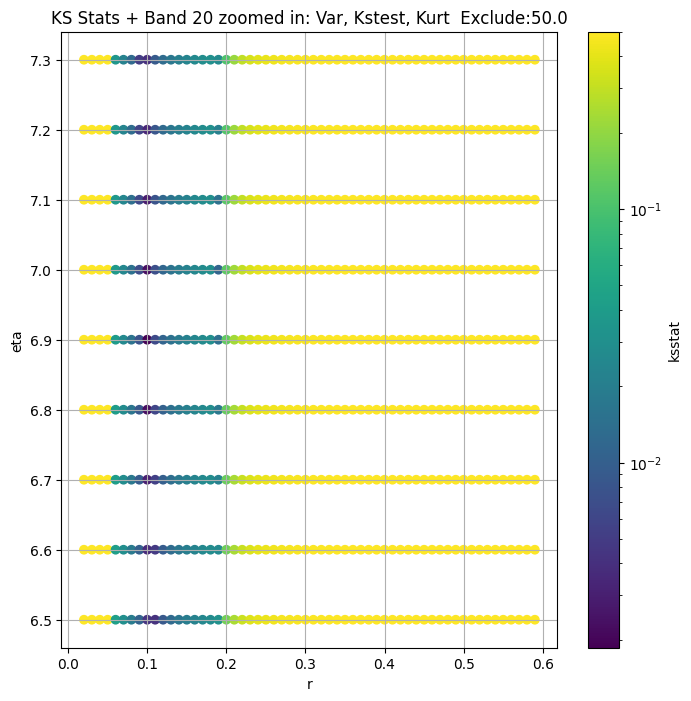

Band 23


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 23, 25.0 + 100 = 125, ksstat: 0.002503908244146341, var: 7205483794297.068


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 23, 25.0 + 75 = 100, ksstat: 0.0019134843297763382, var: 7270076658381.725


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 23, 25.0 + 50 = 75, ksstat: 0.0013814675443779671, var: 7341596713143.014


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 23, 25.0 + 25 = 50, ksstat: 0.000939508194429825, var: 7423245673630.563


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 23, 25.0 + 0 = 25, ksstat: 0.0005293586634348424, var: 7521918865241.804


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 23, 25.0 + -25 = 0, ksstat: 0.0014439361791130922, var: 7693020803365.627
Number of samples: 100000, Without approximation : 2137344.0


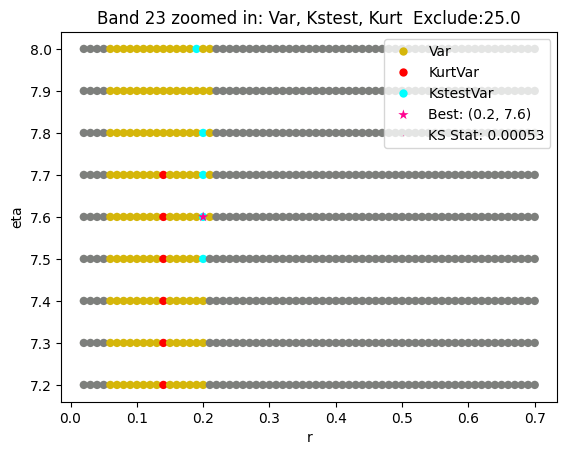

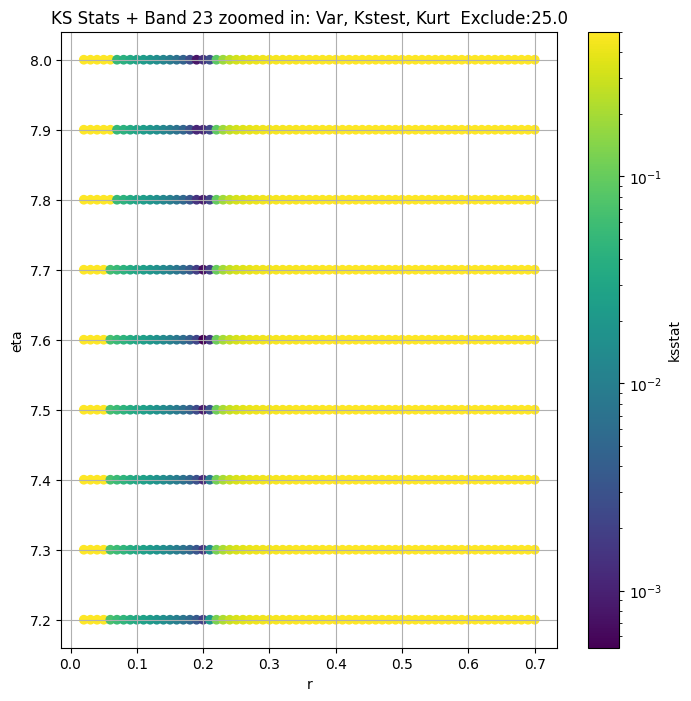

Band 26


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 26, 0.0 + 100 = 100, ksstat: 0.0034085728041603203, var: 3022784307518.6685


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 26, 0.0 + 75 = 75, ksstat: 0.0028841494958370267, var: 3061353797508.89


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 26, 0.0 + 50 = 50, ksstat: 0.0023474709603671373, var: 3105461675520.306


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 26, 0.0 + 25 = 25, ksstat: 0.0016631550632658365, var: 3158929517084.114


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 26, 0.0 + 0 = 0, ksstat: 0.0006515677471151254, var: 3254223044640.0996
Number of samples: 100000, Without approximation : 5931264.0


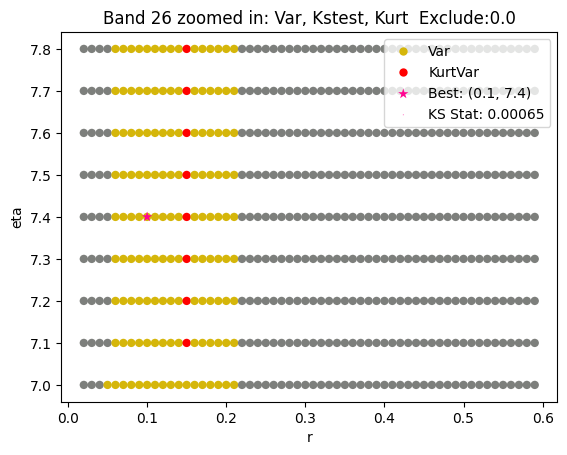

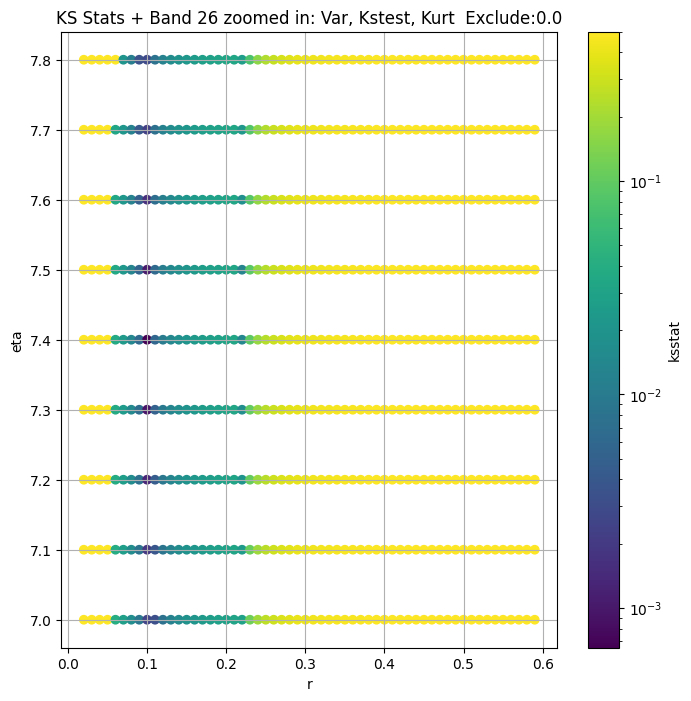

Band 30


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 30, 0.0 + 100 = 100, ksstat: 0.00436639794551421, var: 41287213134.08329


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 30, 0.0 + 75 = 75, ksstat: 0.004055473206634859, var: 41936678333.32487


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 30, 0.0 + 50 = 50, ksstat: 0.0033347465419997224, var: 42676897987.572975


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 30, 0.0 + 25 = 25, ksstat: 0.002655293427944759, var: 43571559025.70588


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 30, 0.0 + 0 = 0, ksstat: 0.0021488126533579233, var: 45077196257.25905
Number of samples: 100000, Without approximation : 4459008.0


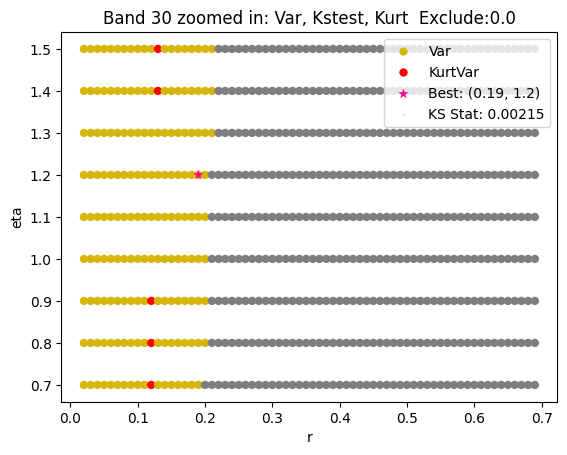

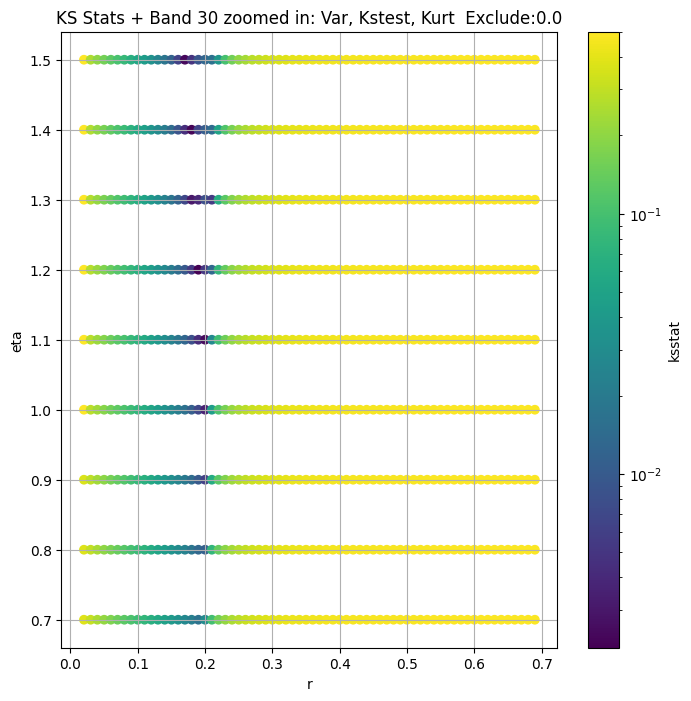

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,kstest_stat_initial,initial_r,initial_eta,initial_scale,initial_exclude_cutoff,best_augmented_var,kstest_stat_cutoff_0.05,kstest_stat_best,best_r,best_eta,best_scale,best_exclude_cutoff,n_pval_0.05
band,,,,,,,,,,,,,,,,,,,,
2,2.832722e+14,2.434444e+14,3.325068e+14,9.531164,2.694812,15.466679,1536.0,0.008137,0.1,9.8,5.664004e-07,0.0,2.832722e+14,0.034542,0.008137,0.10,9.8,5.664004e-07,0.0,28023
5,5.272261e+14,4.412827e+14,6.209130e+14,38.215220,31.712398,44.757256,4608.0,0.011065,0.1,8.1,1.872667e-06,75.0,2.333238e+14,0.019970,0.011000,0.08,8.1,1.337616e-12,50.0,15552
8,7.540515e+13,6.223850e+13,9.270398e+13,59.027773,22.559526,111.580628,13056.0,0.006001,0.2,8.9,1.000000e+05,0.0,7.540515e+13,0.011873,0.006001,0.20,8.9,1.000000e+05,0.0,49572
11,1.100608e+13,8.295259e+12,1.571146e+13,171.606859,11.703311,428.210304,36096.0,0.003046,0.2,15.0,1.652971e+03,150.0,7.231252e+12,0.007144,0.002787,0.18,15.0,7.927911e+01,125.0,231274
14,2.499094e+14,2.258673e+14,2.756166e+14,12.881619,10.170918,16.534709,99840.0,0.028318,0.1,0.1,2.024814e+01,25.0,2.401769e+14,0.004296,0.027128,0.12,-0.2,5.659470e+04,25.0,2632
17,3.873803e+14,3.634429e+14,4.138611e+14,4.352694,2.846702,8.766469,277248.0,0.005174,0.1,7.1,1.056431e-05,0.0,3.873803e+14,0.002579,0.005174,0.10,7.1,1.056431e-05,0.0,69312
20,8.279530e+13,7.679648e+13,8.937748e+13,6.679419,4.341862,12.376772,769536.0,0.001861,0.1,6.9,2.678475e-06,50.0,7.852915e+13,0.001548,0.001861,0.10,6.9,2.678475e-06,50.0,547843
23,7.693021e+12,7.270887e+12,8.157248e+12,2.937584,1.708110,6.831796,2137344.0,0.000529,0.2,7.6,3.117624e+04,25.0,7.521919e+12,0.000929,0.000529,0.20,7.6,3.117624e+04,25.0,6847222
26,3.254223e+12,3.037162e+12,3.503769e+12,5.574509,3.256359,14.406480,5931264.0,0.000652,0.1,7.4,6.402980e-08,0.0,3.254223e+12,0.000558,0.000652,0.10,7.4,6.402980e-08,0.0,4448448


In [15]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

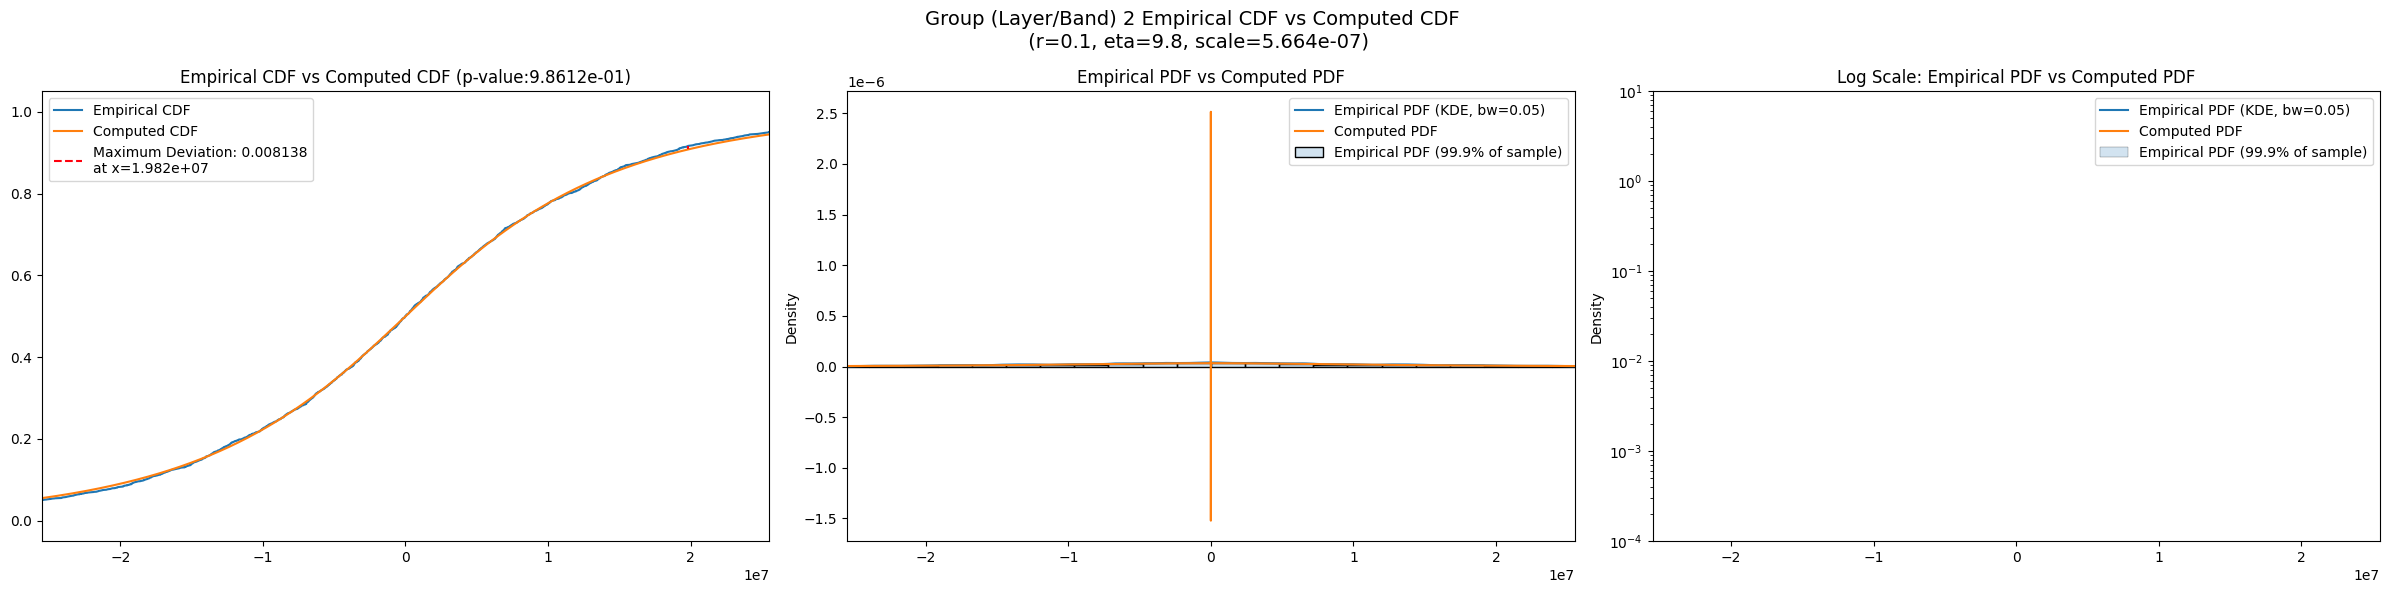

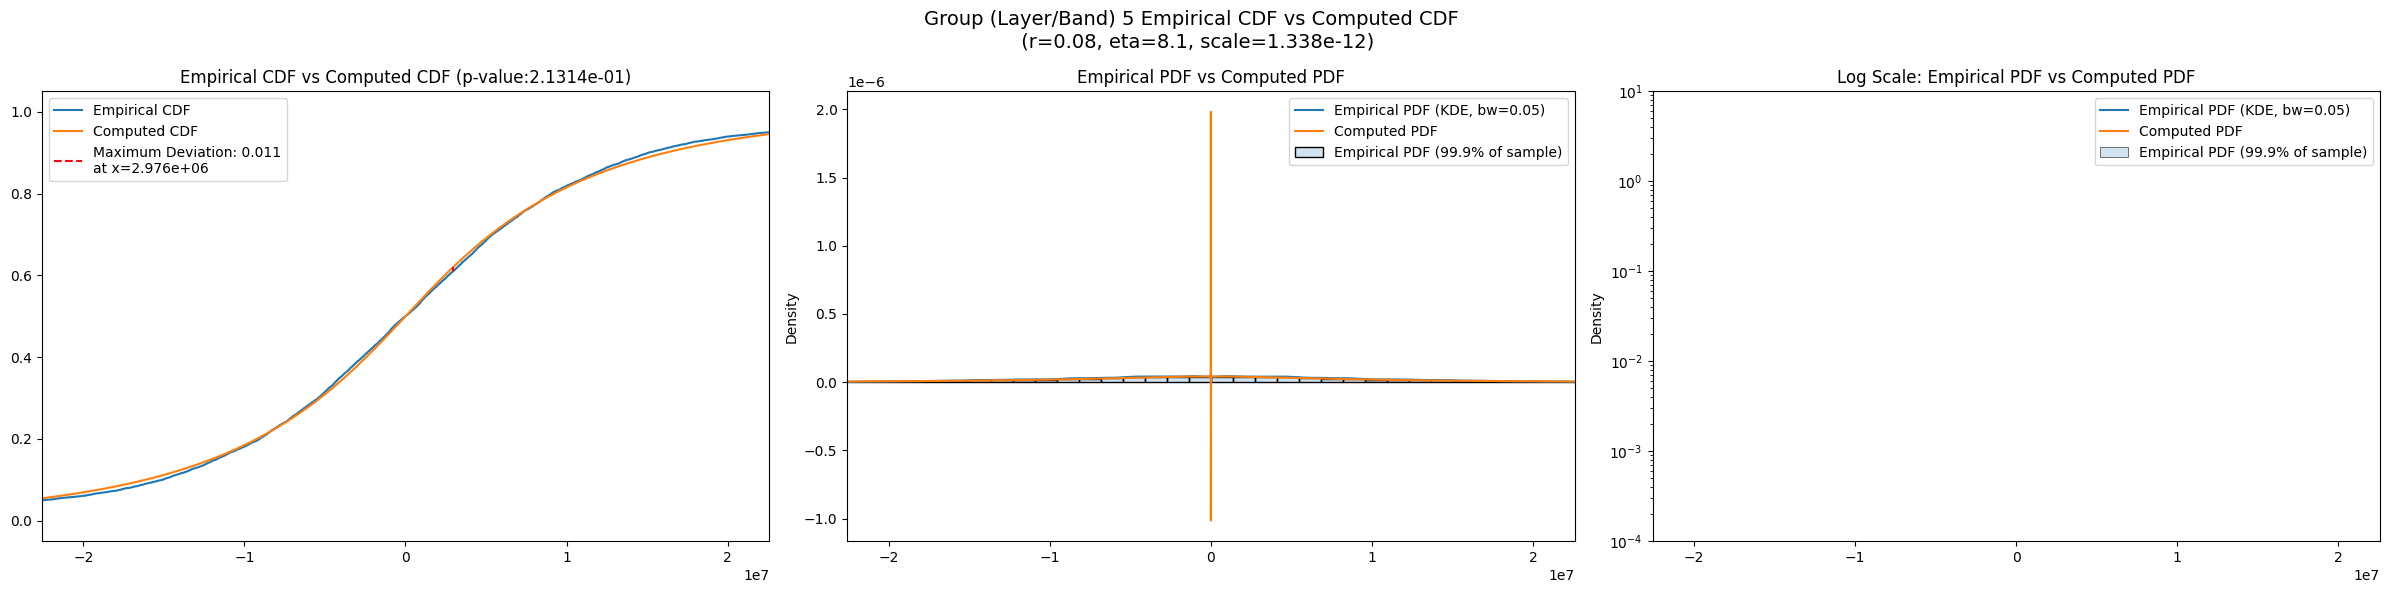

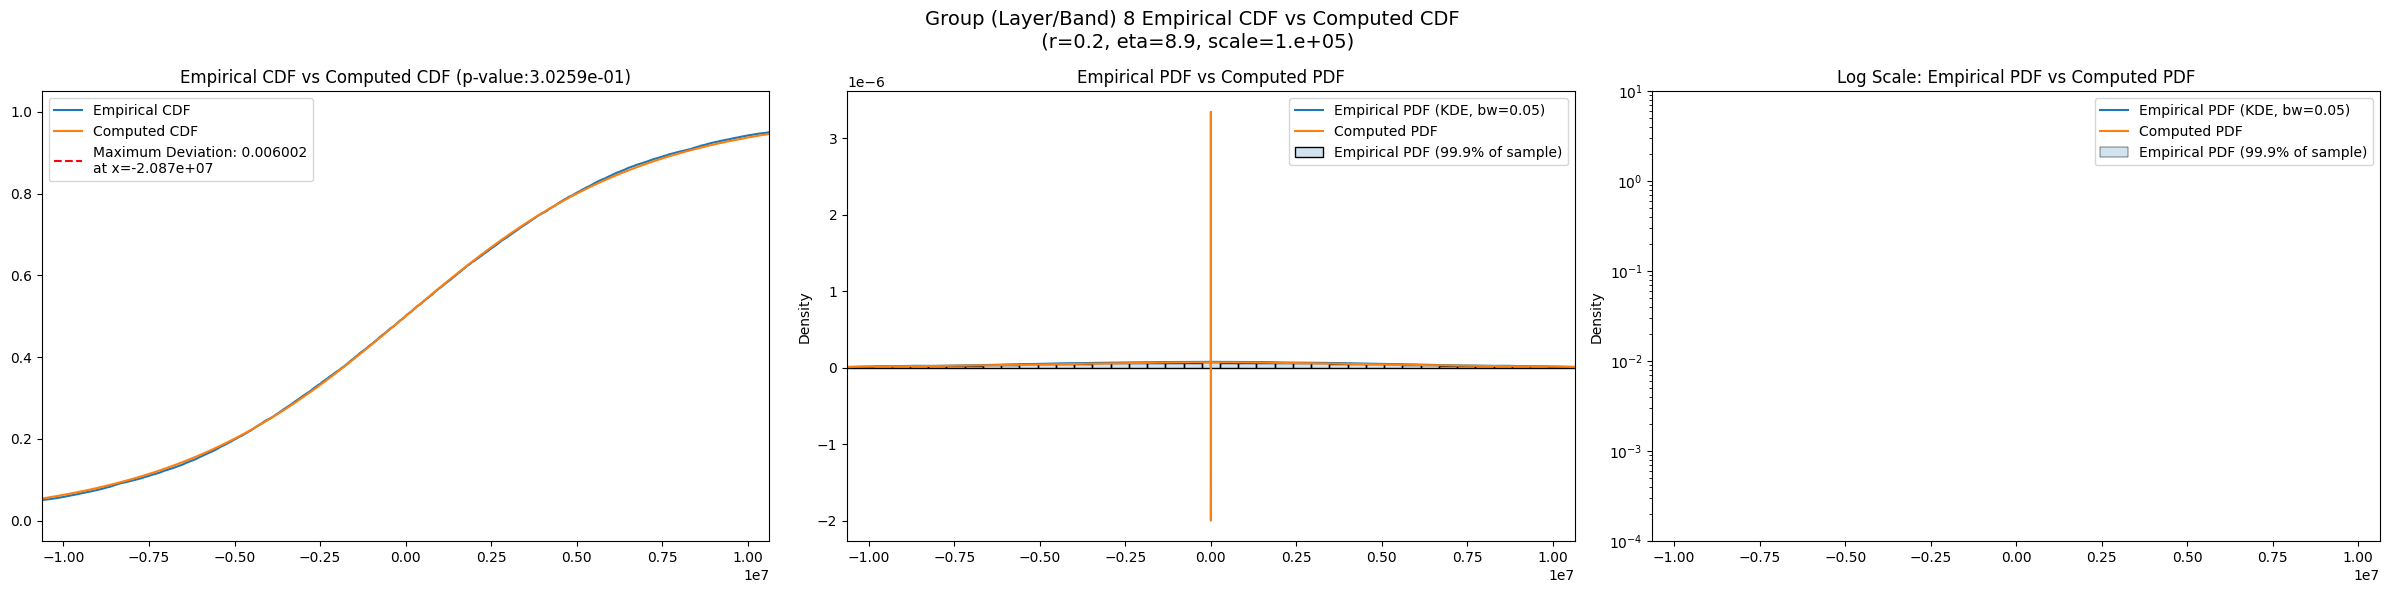

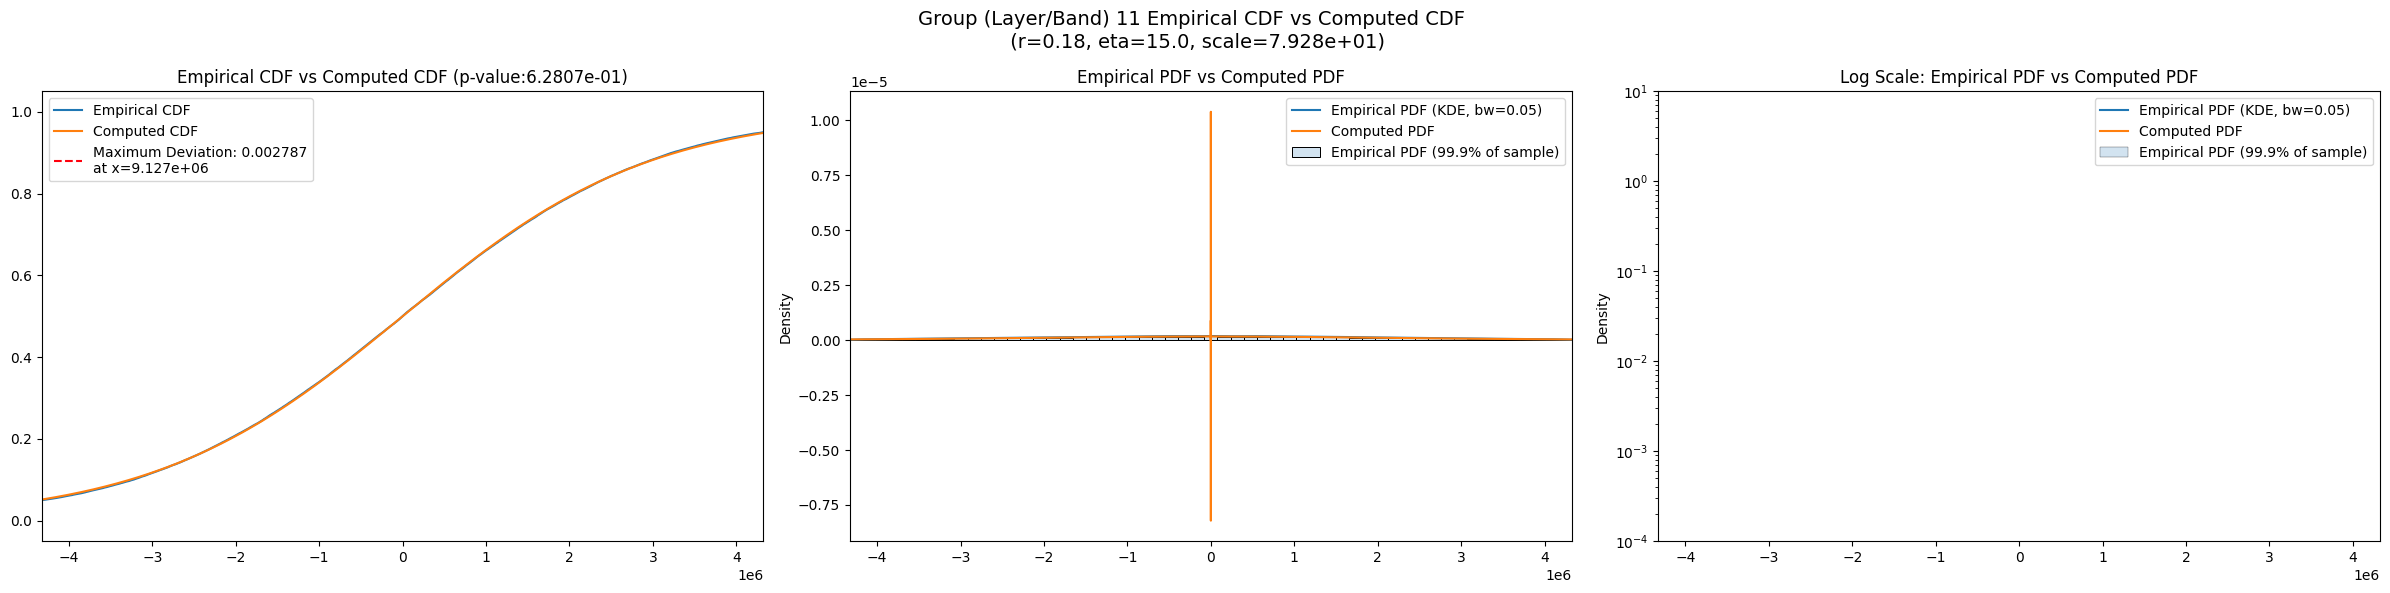

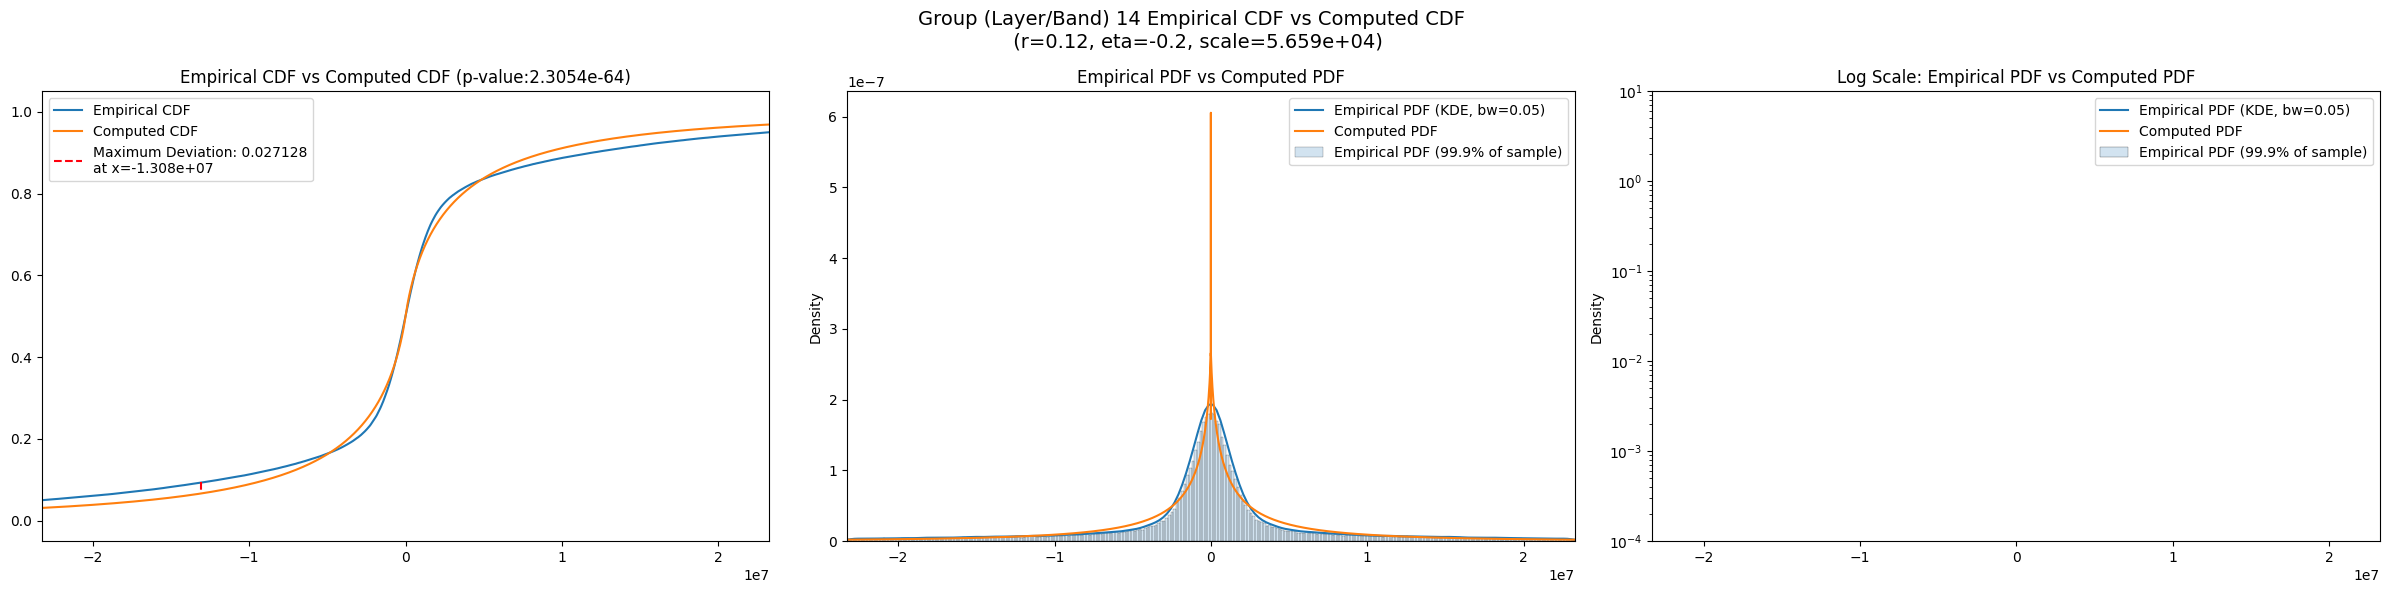

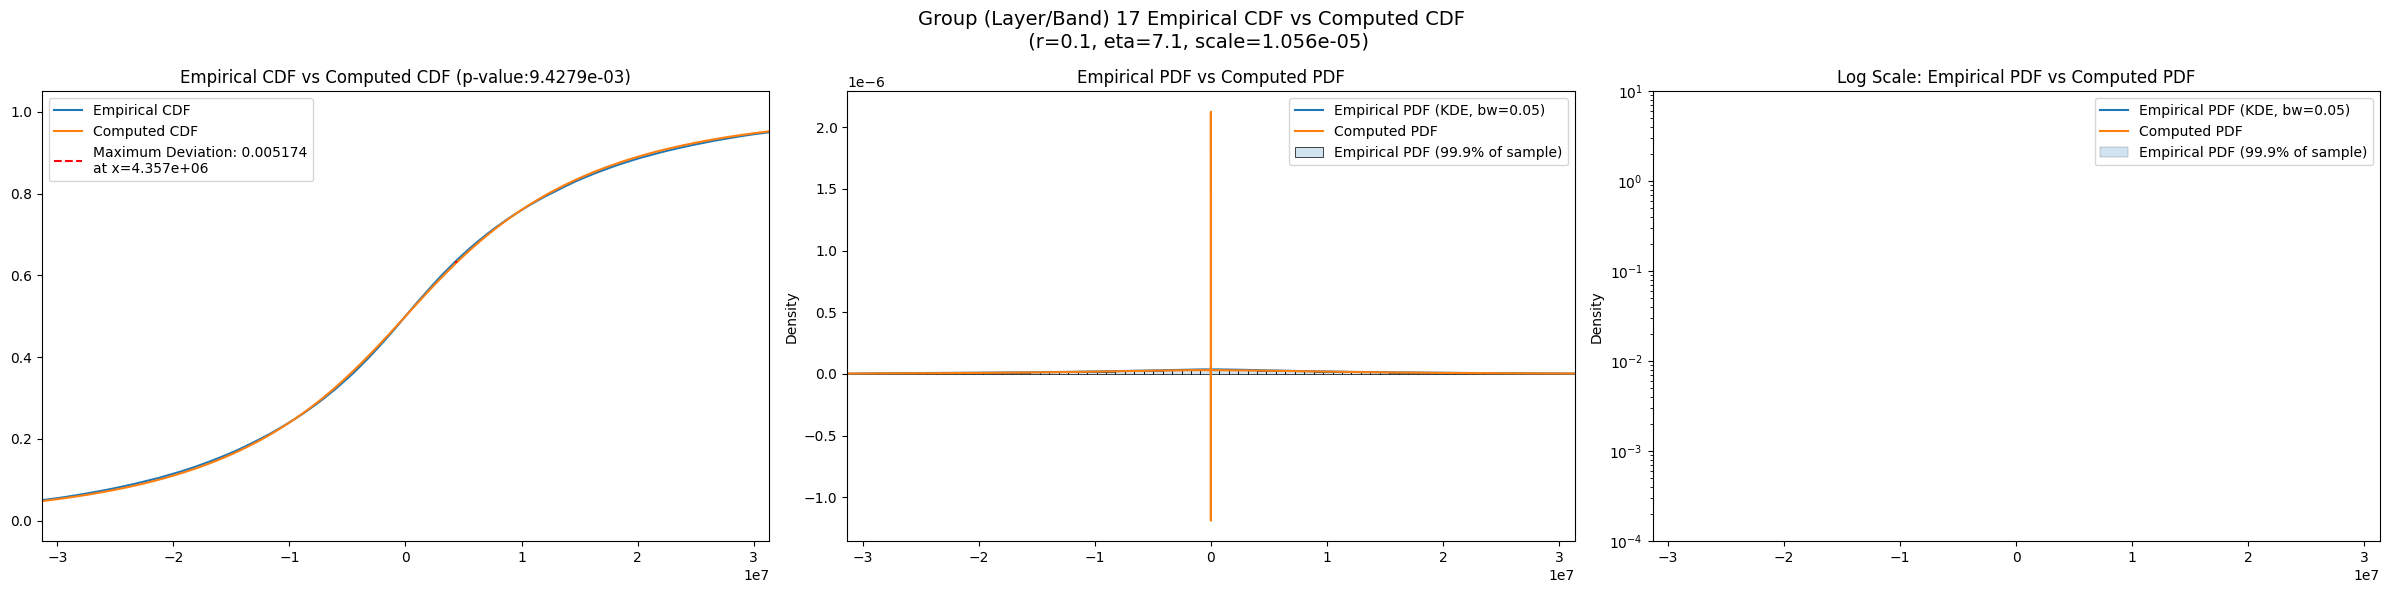

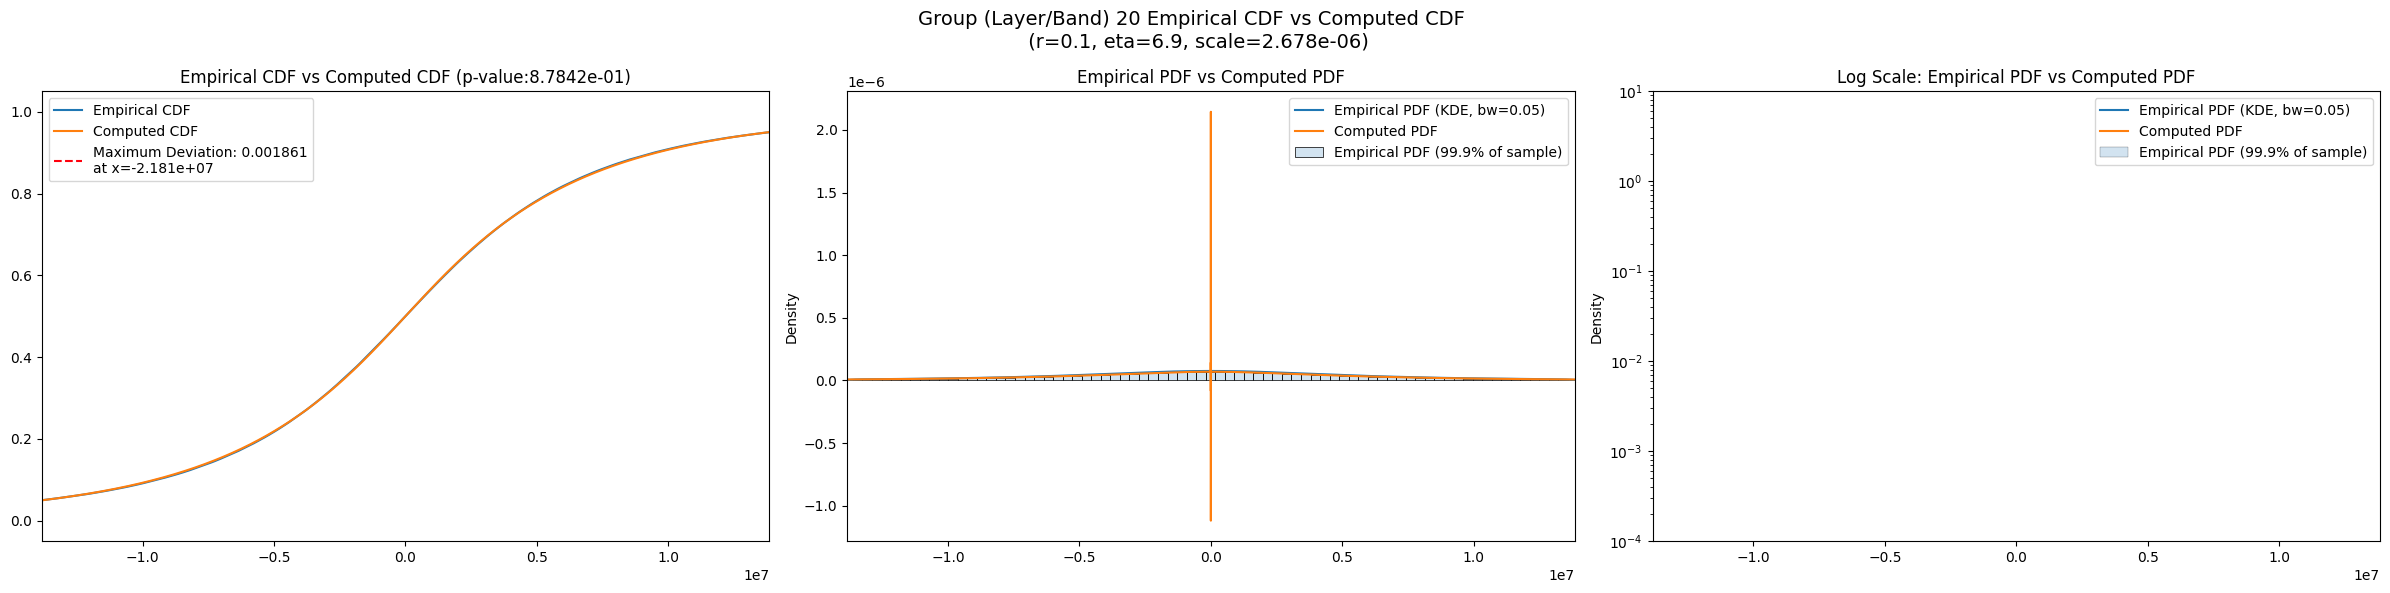

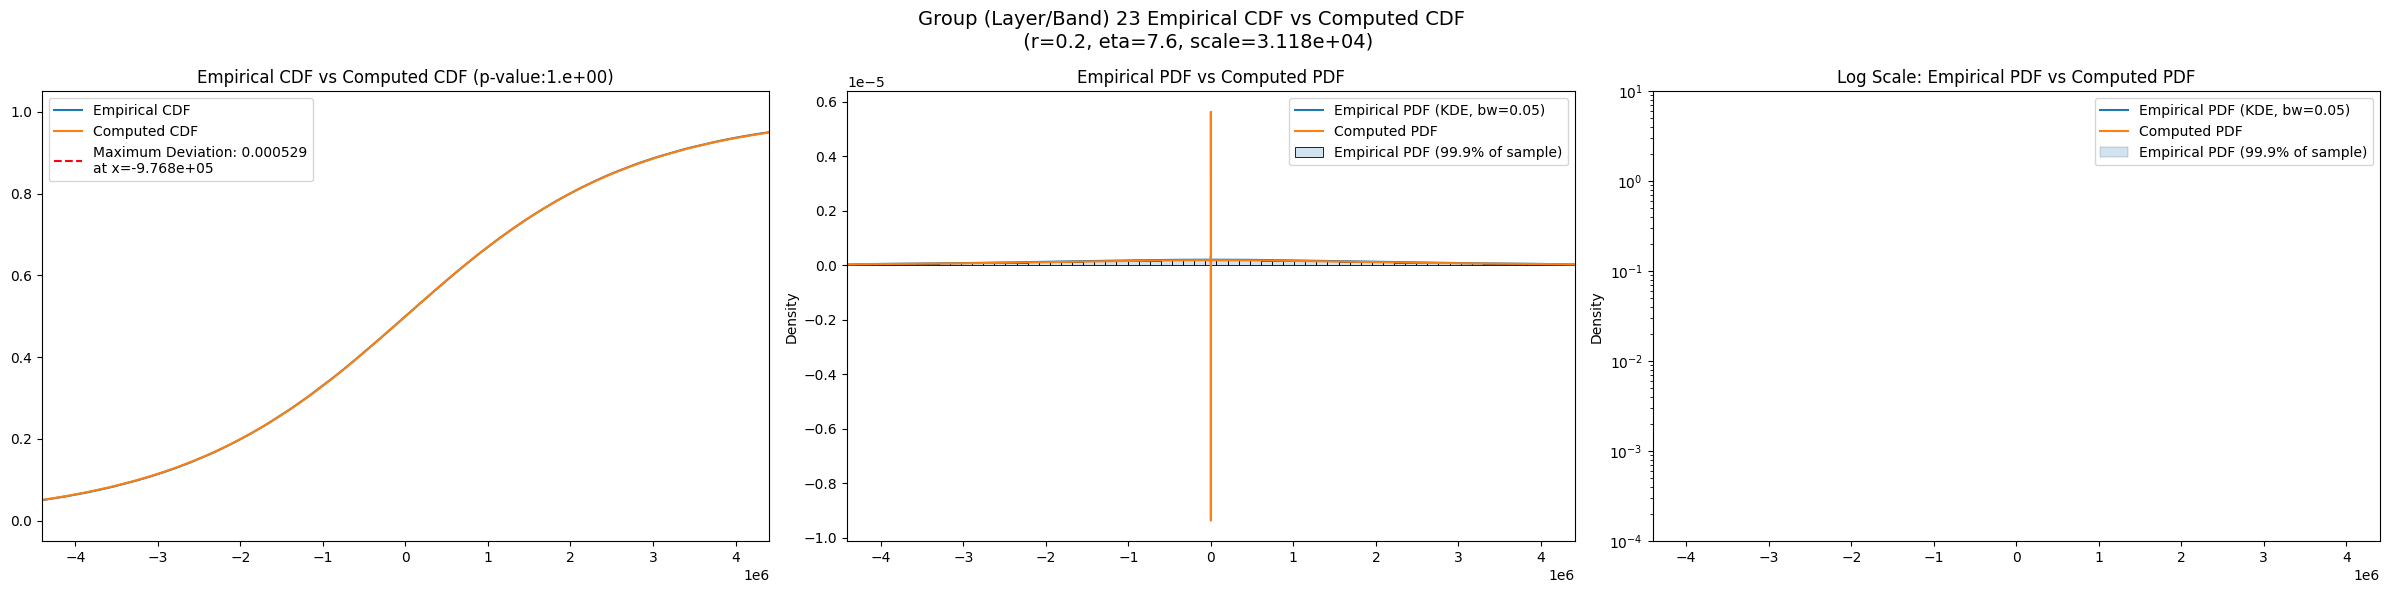

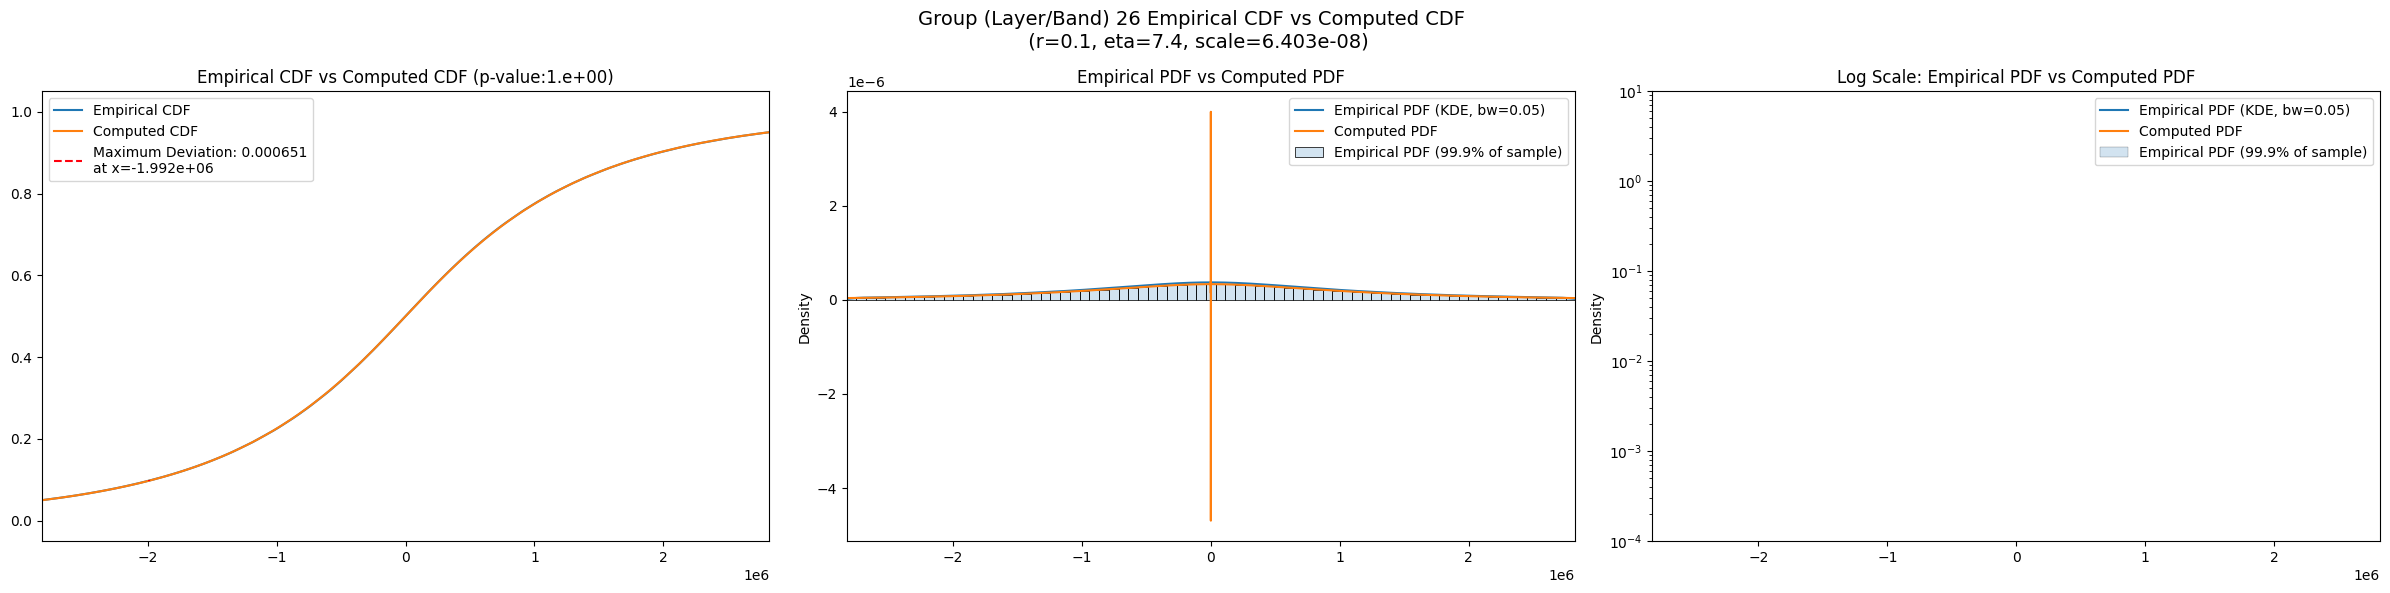

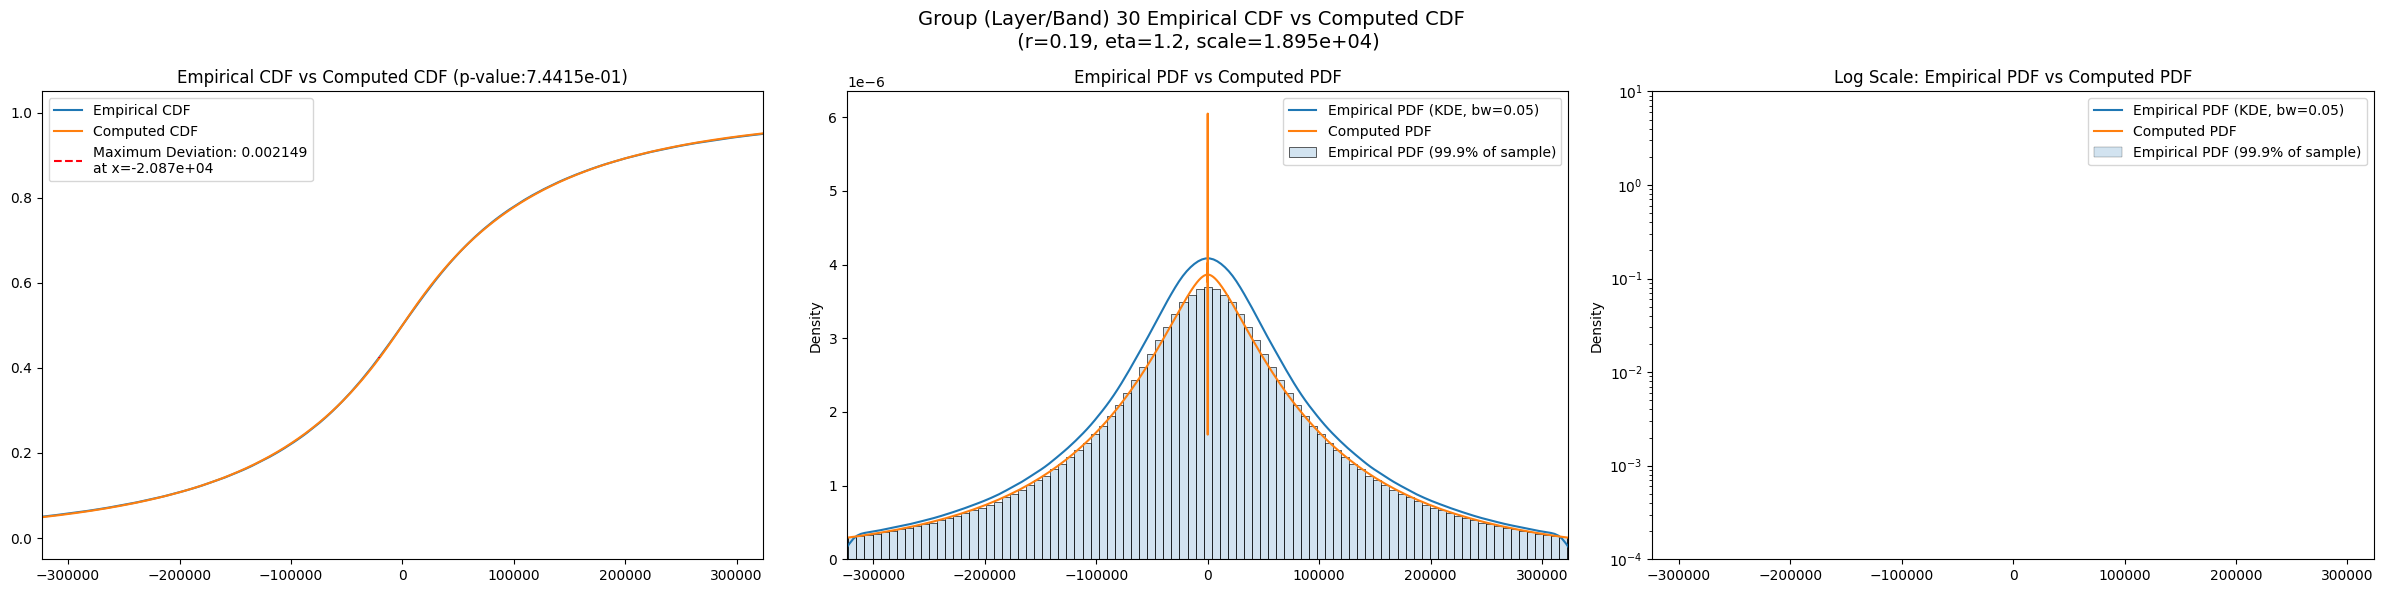

In [16]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [17]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [18]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,kstest_stat_initial,initial_r,initial_eta,...,param_gaussian,kstest_stat_gaussian,kstest_pval_gaussian,param_laplace,kstest_stat_laplace,kstest_pval_laplace,param_t,kstest_stat_t,kstest_pval_t,kstest_pval_gengamma
band,,,,,,,,,,,,,,,,,,,,,
2,2.832722e+14,2.434444e+14,3.325068e+14,9.531164,2.694812,15.466679,1536.0,0.008137,0.1,9.8,...,1000000.0,0.414644,1.415150e-239,1000000.0,0.379722,1.426850e-199,1000000.0,0.356560,2.839870e-175,9.999431e-01
5,5.272261e+14,4.412827e+14,6.209130e+14,38.215220,31.712398,44.757256,4608.0,0.011065,0.1,8.1,...,1000000.0,0.403722,0.000000e+00,1000000.0,0.366082,0.000000e+00,1000000.0,0.342401,0.000000e+00,6.285697e-01
8,7.540515e+13,6.223850e+13,9.270398e+13,59.027773,22.559526,111.580628,13056.0,0.006001,0.2,8.9,...,1000000.0,0.342969,0.000000e+00,1000000.0,0.298452,0.000000e+00,1000000.0,0.274406,0.000000e+00,7.324291e-01
11,1.100608e+13,8.295259e+12,1.571146e+13,171.606859,11.703311,428.210304,36096.0,0.003046,0.2,15.0,...,1000000.0,0.202803,0.000000e+00,1000000.0,0.160586,0.000000e+00,1000000.0,0.135187,0.000000e+00,9.411331e-01
14,2.499094e+14,2.258673e+14,2.756166e+14,12.881619,10.170918,16.534709,99840.0,0.028318,0.1,0.1,...,1000000.0,0.225450,0.000000e+00,1000000.0,0.181863,0.000000e+00,1000000.0,0.158133,0.000000e+00,2.917617e-64
17,3.873803e+14,3.634429e+14,4.138611e+14,4.352694,2.846702,8.766469,277248.0,0.005174,0.1,7.1,...,1000000.0,0.414517,0.000000e+00,1000000.0,0.379411,0.000000e+00,1000000.0,0.356221,0.000000e+00,7.131521e-07
20,8.279530e+13,7.679648e+13,8.937748e+13,6.679419,4.341862,12.376772,769536.0,0.001861,0.1,6.9,...,1000000.0,0.345663,0.000000e+00,1000000.0,0.300964,0.000000e+00,1000000.0,0.276929,0.000000e+00,9.671154e-03
23,7.693021e+12,7.270887e+12,8.157248e+12,2.937584,1.708110,6.831796,2137344.0,0.000529,0.2,7.6,...,1000000.0,0.192366,0.000000e+00,1000000.0,0.150187,0.000000e+00,1000000.0,0.124679,0.000000e+00,5.869322e-01
26,3.254223e+12,3.037162e+12,3.503769e+12,5.574509,3.256359,14.406480,5931264.0,0.000652,0.1,7.4,...,1000000.0,0.080862,0.000000e+00,1000000.0,0.041969,0.000000e+00,1000000.0,0.013845,0.000000e+00,1.299214e-02


## Results

In [19]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [20]:
master_df.filter(regex="kstest_stat.*")

,kstest_stat_initial,kstest_stat_cutoff_0.05,kstest_stat_best,kstest_stat_gaussian,kstest_stat_laplace,kstest_stat_t
band,,,,,,
2,0.008137,0.034542,0.008137,0.414644,0.379722,0.356560
5,0.011065,0.019970,0.011000,0.403722,0.366082,0.342401
8,0.006001,0.011873,0.006001,0.342969,0.298452,0.274406
11,0.003046,0.007144,0.002787,0.202803,0.160586,0.135187
14,0.028318,0.004296,0.027128,0.225450,0.181863,0.158133
17,0.005174,0.002579,0.005174,0.414517,0.379411,0.356221
20,0.001861,0.001548,0.001861,0.345663,0.300964,0.276929
23,0.000529,0.000929,0.000529,0.192366,0.150187,0.124679
26,0.000652,0.000558,0.000652,0.080862,0.041969,0.013845


In [21]:
master_df.filter(regex="best.*")

,best_augmented_var,kstest_stat_best,best_r,best_eta,best_scale,best_exclude_cutoff
band,,,,,,
2,2.832722e+14,0.008137,0.10,9.8,5.664004e-07,0.0
5,2.333238e+14,0.011000,0.08,8.1,1.337616e-12,50.0
8,7.540515e+13,0.006001,0.20,8.9,1.000000e+05,0.0
11,7.231252e+12,0.002787,0.18,15.0,7.927911e+01,125.0
14,2.401769e+14,0.027128,0.12,-0.2,5.659470e+04,25.0
17,3.873803e+14,0.005174,0.10,7.1,1.056431e-05,0.0
20,7.852915e+13,0.001861,0.10,6.9,2.678475e-06,50.0
23,7.521919e+12,0.000529,0.20,7.6,3.117624e+04,25.0
26,3.254223e+12,0.000652,0.10,7.4,6.402980e-08,0.0
